<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/research/carry/Perp_Funding_Carry_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perp Funding Effects - Initial Exploratory Analysis

* Does funding rate predict future funding returns?
* Does funding rate predict future price moves?


In [ ]:
# snippet: rw load rwrtools v0.4

# lists of libraries: rwRtools dependencies (install but don't load) and libs_to_load (install and load)
dependencies <- c(
  "pacman", "ttr", "googleauthr", "doparallel", "googlecloudstorager", 
  "iterators", "R.methodsS3", "openssl", "foreach", "xts", "R.oo", "feather", 
  "R.utils"
)
libs_to_load <- c("tidyverse", "lubridate", "purrr", "stringr", "zoo", "glue", "here", "roll")

# comment out next two lines if not loading rsims
rsims_dependencies <- c("stringr", "lubridate", "roll", "Rcpp")
dependencies <- c(dependencies, rsims_dependencies)

# capitalisation of call to CRAN may not always match capitalisation of package name (eg library(doParallel) vs sudo apt install r-cran-doparallel).
install_from_cran <- gsub("^(?!R\\.)([\\w]+)", "\\L\\1", unique(c(libs_to_load, dependencies)), perl = TRUE)  # convert to lowercase all letters other than an "R" at the start followed by "."

msg1 <- system2('sudo', args = c('apt-get', 'update'),
  stdout = TRUE,
  stderr = TRUE,
  wait = TRUE
)

msg2 <- system2(
  'sudo', 
  args = c('apt', 'install', sub('', 'r-cran-', install_from_cran, '-y --fix-missing')),
  stdout = TRUE,
  stderr = TRUE,
  wait = TRUE
)

pacman::p_load(char = libs_to_load, install = FALSE)

# install and load rwRtools from GH (sans dependencies)
pacman::p_load_current_gh("RWLab/rwRtools", dependencies = FALSE)

# install and load rsims from GH (sans dependencies)
# pacman::p_load_current_gh("Robot-Wealth/rsims", dependencies = FALSE)

# output messages from install - optional, for debugging
# msg

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

* checking for file ‘/tmp/RtmpBBdhOF/remotes3b37be29e6/RWLab-rwRtools-985e440/DESCRIPTION’ ... OK
* preparing ‘rwRtools’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘rwRtools_0.1.17.tar.gz’



# What data do we want?

* Perp prices
* Perp funding rates

In [ ]:
rwlab_data_auth()

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/auth?client_id=603366585132-0l5tra7gl2i20iftqangp7iskte4f3s0.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code



Enter authorization code: 4/1AdQt8qhcUpghOzHyAduYnS6e7QKAFmW2CZGMHyMODltgUJ8b6xeQaiFi_4w


In [ ]:
# snippet: rw crypto load ftx futures v0.1
futures <- rwRtools::crypto_get_futures()

futures %>% 
  summarise(
    min_date = min(date), 
    max_date = max(date)
  )

# snippet: rw crypto load ftx perpetual funding rates v0.1
perp_rate <- rwRtools::crypto_get_perp_rates()

perp_rate %>%
  summarise(
    min_date = min(date), 
    max_date = max(date)
  )

ℹ Downloading ftx_futures_ohlc_1h.feather

✔ Saved ftx_futures_ohlc_1h.feather to ftx/ftx_futures_ohlc_1h.feather  ( 196.1…





File successfully transferred


min_date,max_date
<dttm>,<dttm>
2019-07-20 12:00:00,2022-07-26 02:00:00


ℹ Downloading ftx_perpetual_funding_rates.feather

✔ Saved ftx_perpetual_funding_rates.feather to ftx/ftx_perpetual_funding_rates.…





File successfully transferred


min_date,max_date
<dttm>,<dttm>
2019-03-06 15:00:00,2022-07-26 02:00:00


# Prepare Data for Analysis

Calculate returns

* Positive rate = longs pay shorts
* Negative rate = shorts pay longs

Calculate returns from funding accrual and price change. 

And work with funding rates that have the same sign as returns to longs. 

In [ ]:
funding_data <- futures %>% 
  inner_join(perp_rate, by = c('ticker','date')) %>%
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(
    avg_1 = -rate,
    avg_3 = roll_mean(-rate, 3),
    avg_6 = roll_mean(-rate, 6),
    avg_12 = roll_mean(-rate, 9),
    avg_18 = roll_mean(-rate, 12),
    avg_24 = roll_mean(-rate, 24),
    avg_30 = roll_mean(-rate, 30),
    avg_36 = roll_mean(-rate, 36),
    avg_42 = roll_mean(-rate, 42),
    avg_48 = roll_mean(-rate, 48),
    avg_54 = roll_mean(-rate, 54),
    avg_60 = roll_mean(-rate, 60),
    price_change = log(lead(close) / close),
    funding_accrual = -lead(log(rate + 1)),
    total_returns = price_change + funding_accrual
  ) %>% 
  ungroup() %>%
  na.omit()

# Auto-correlation in Funding

Look at the decay of the funding for Bitcoin

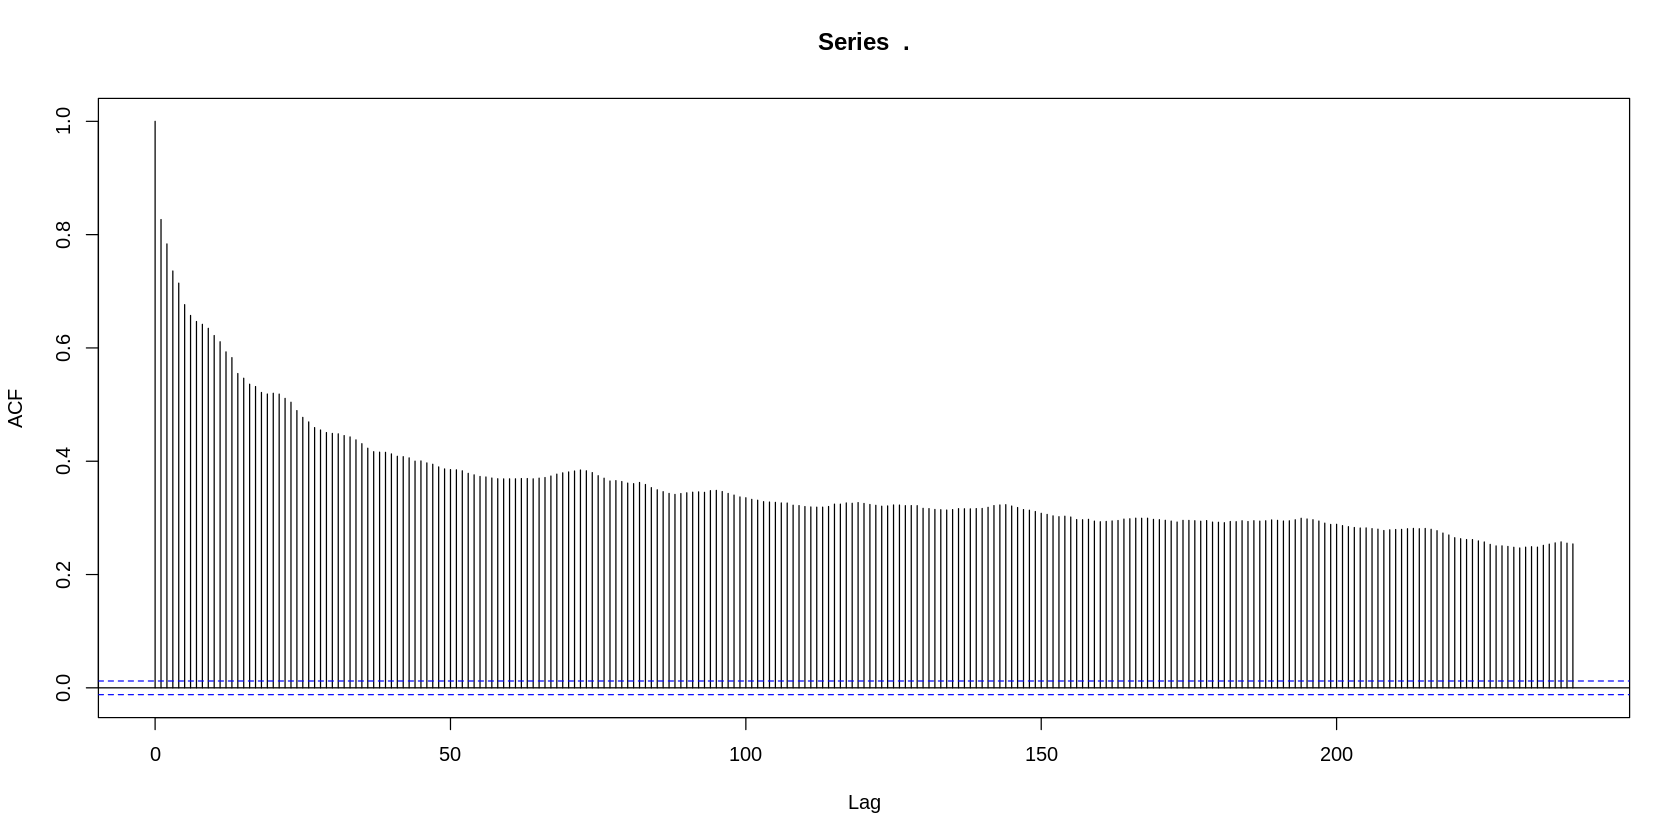

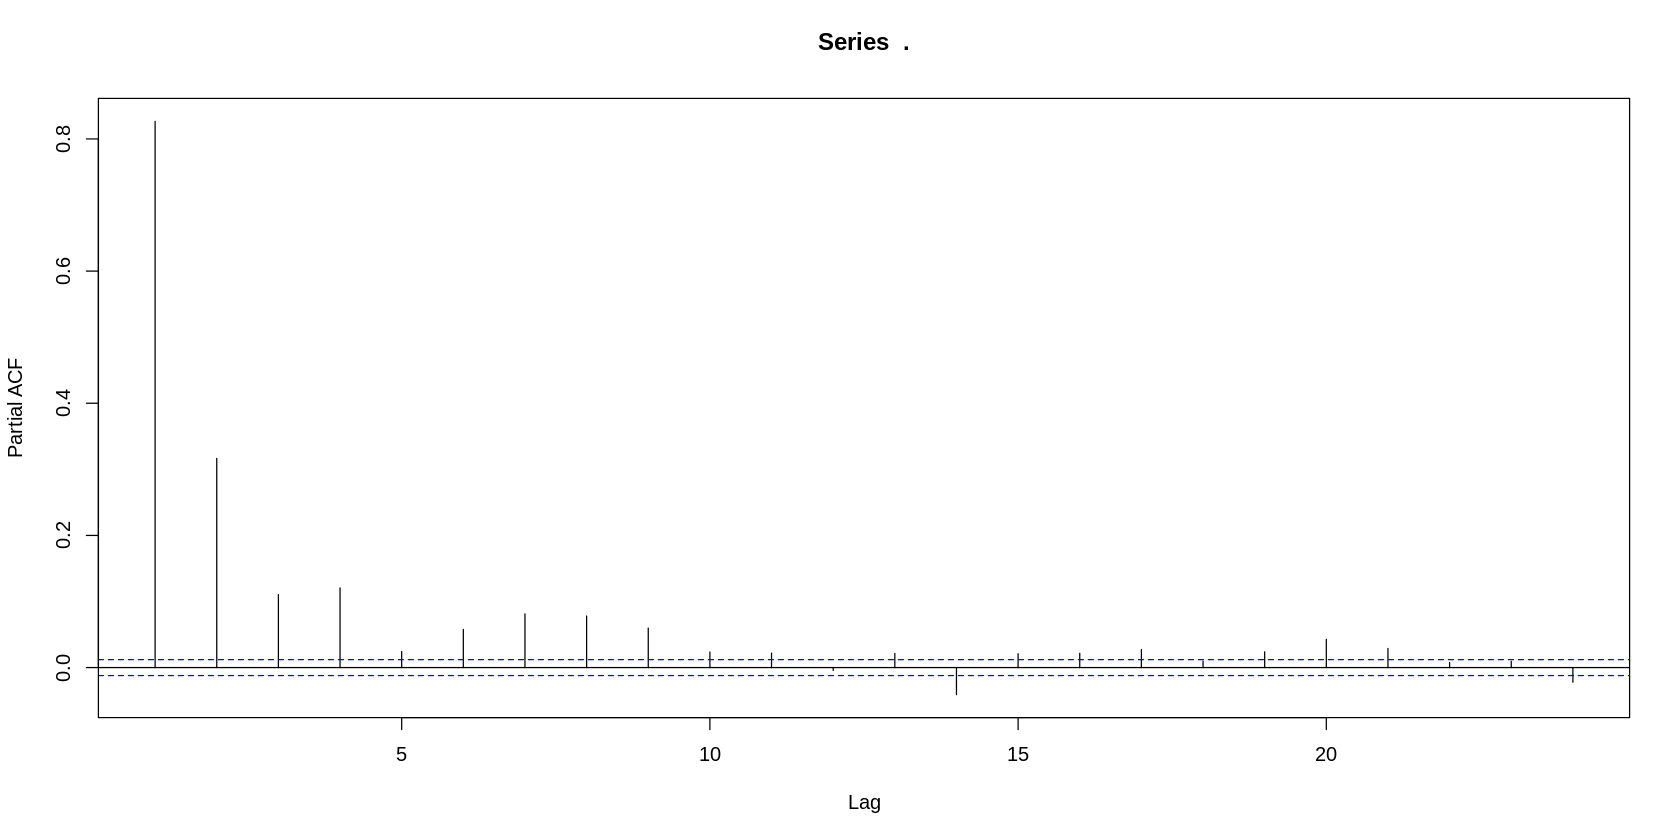

In [ ]:
the_ticker <- 'BTC-PERP'

# autocorrelation
funding_data %>%
  filter(ticker == the_ticker) %>%
  pull(funding_accrual) %>%
  acf(lag.max = 240)

# partial autocorrelation
funding_data %>%
  filter(ticker == the_ticker) %>%
  pull(funding_accrual) %>%
  pacf(lag.max = 24)

Now let's look at something a bit more wild like CEL

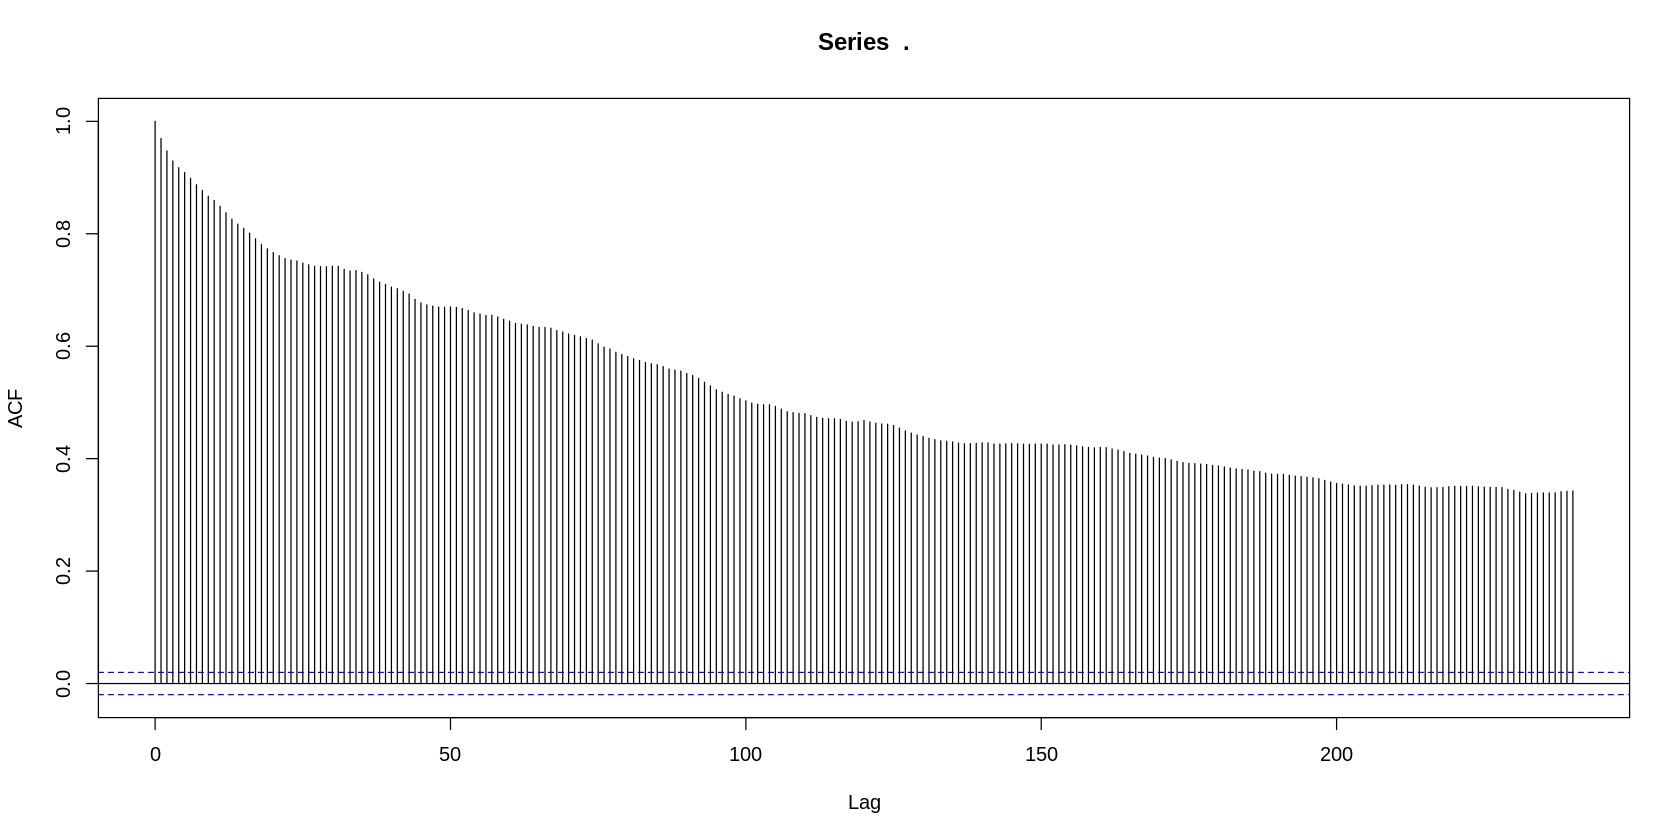

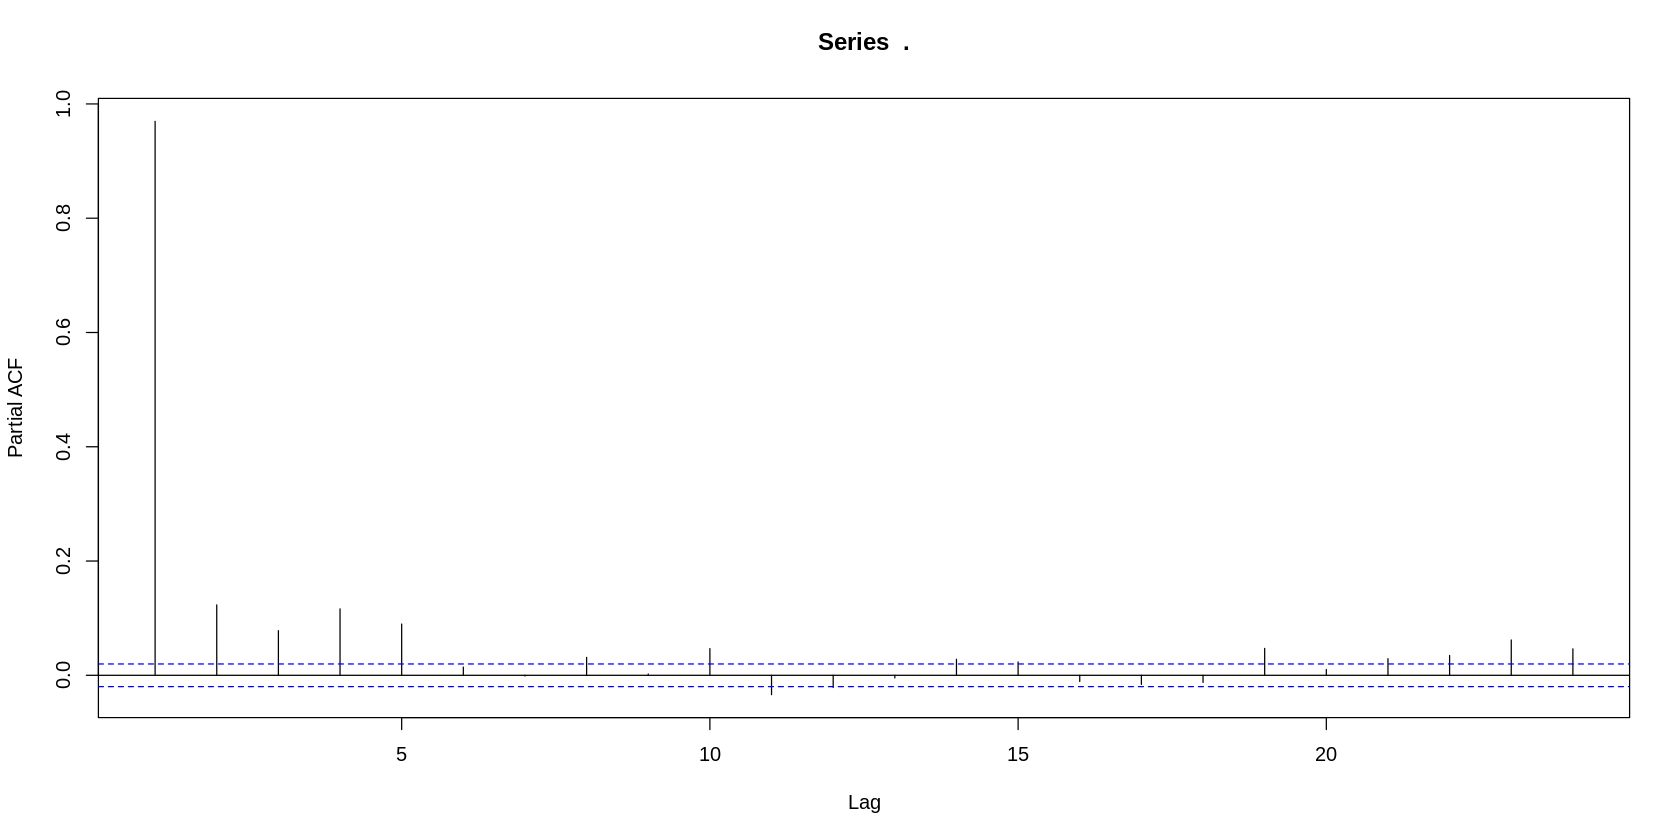

In [ ]:
the_ticker <- 'CEL-PERP'

# autocorrelation
funding_data %>%
  filter(ticker == the_ticker) %>%
  pull(funding_accrual) %>%
  acf(lag.max = 240)

# partial autocorrelation
funding_data %>%
  filter(ticker == the_ticker) %>%
  pull(funding_accrual) %>%
  pacf(lag.max = 24)

It deacays a bit slower... Generally we're seeing that information after about 12 hour isn't that interesting.

Now, just to demonstrate we can look at autocorrelations of the averages.

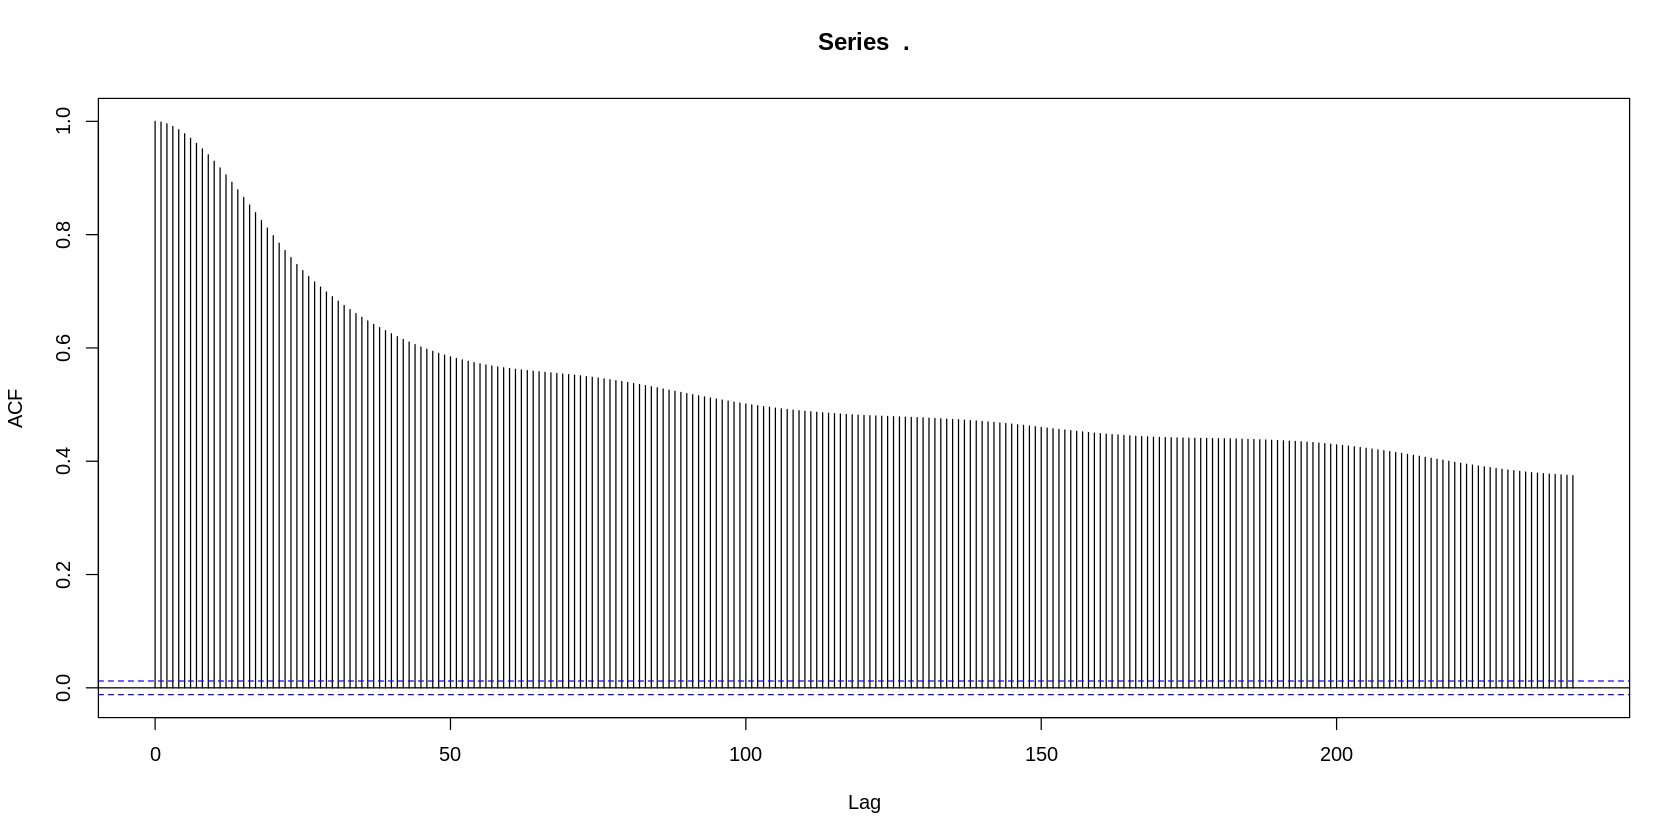

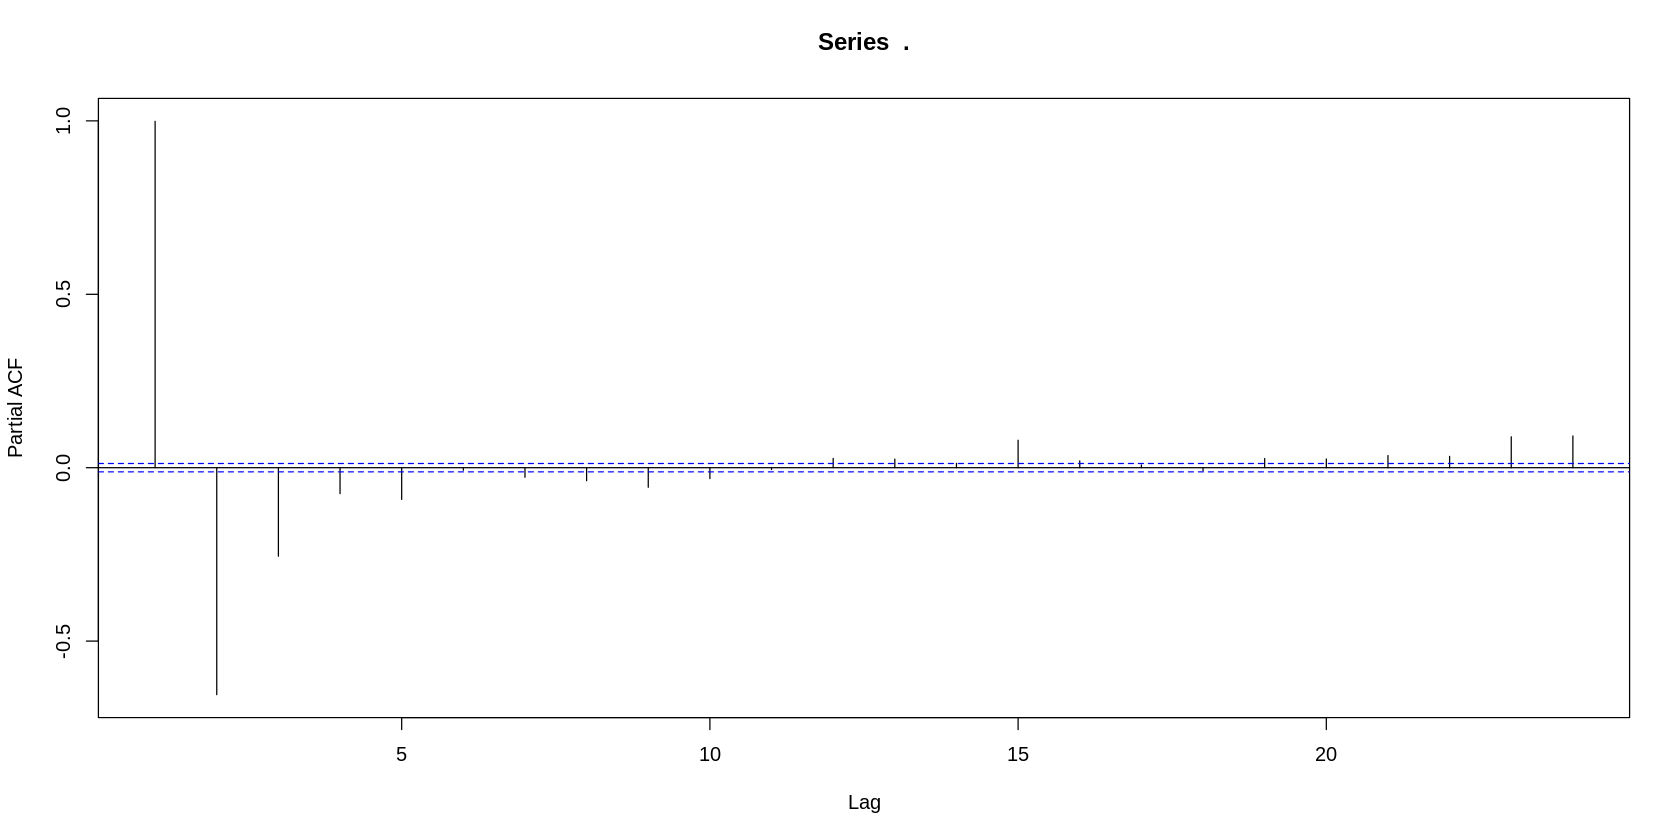

In [ ]:
the_ticker <- 'BTC-PERP'

# autocorrelation
funding_data %>%
  filter(ticker == the_ticker) %>%
  pull(avg_24) %>%
  acf(lag.max = 240)

# partial autocorrelation
funding_data %>%
  filter(ticker == the_ticker) %>%
  pull(avg_24) %>%
  pacf(lag.max = 24)

These decay slower. We know that. We know the overlaps.

# Returns Conditional on 24h avg Funding Rate

For each date, sort by funding rate, plot next hour returns.

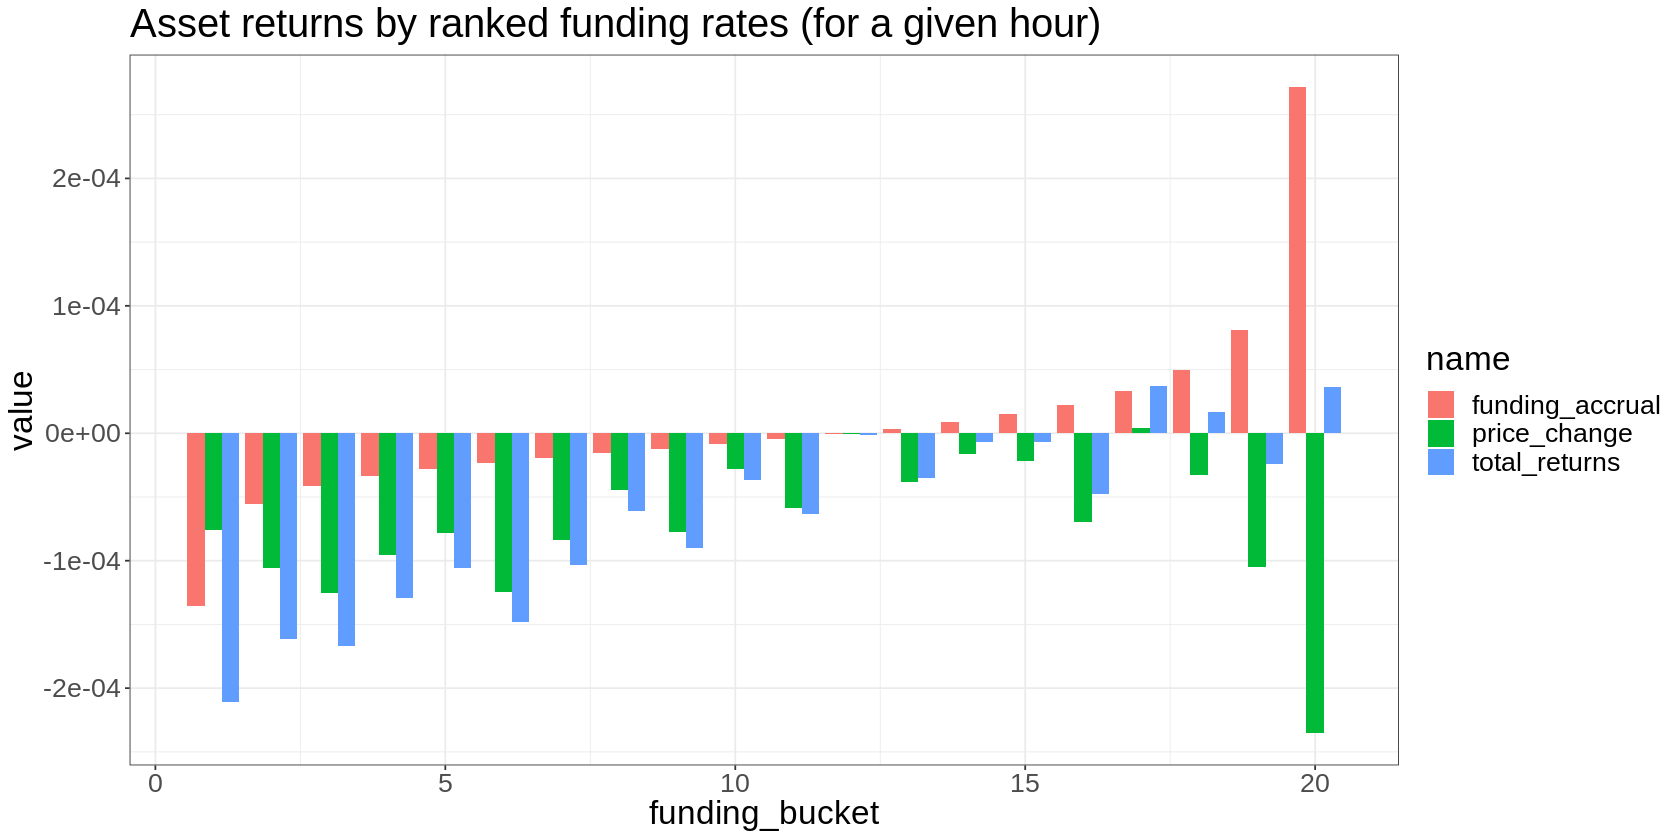

In [ ]:
funding_data %>%
  group_by(date) %>%
  mutate(funding_bucket = ntile(avg_24, 20)) %>% 
  group_by(funding_bucket) %>%
  summarize(
    price_change = mean(price_change),
    funding_accrual = mean(funding_accrual),
    total_returns = mean(total_returns)
  ) %>%
  pivot_longer(-funding_bucket) %>%
  ggplot(aes(x=funding_bucket, y=value, fill=name)) + geom_bar(stat='identity', position = 'dodge') +
    ggtitle('Asset returns by ranked funding rates (for a given hour)')

What if we ignore data or ticker, and sort all our observations. So the largest stuff goes in bucket 20, the most negative in 1.

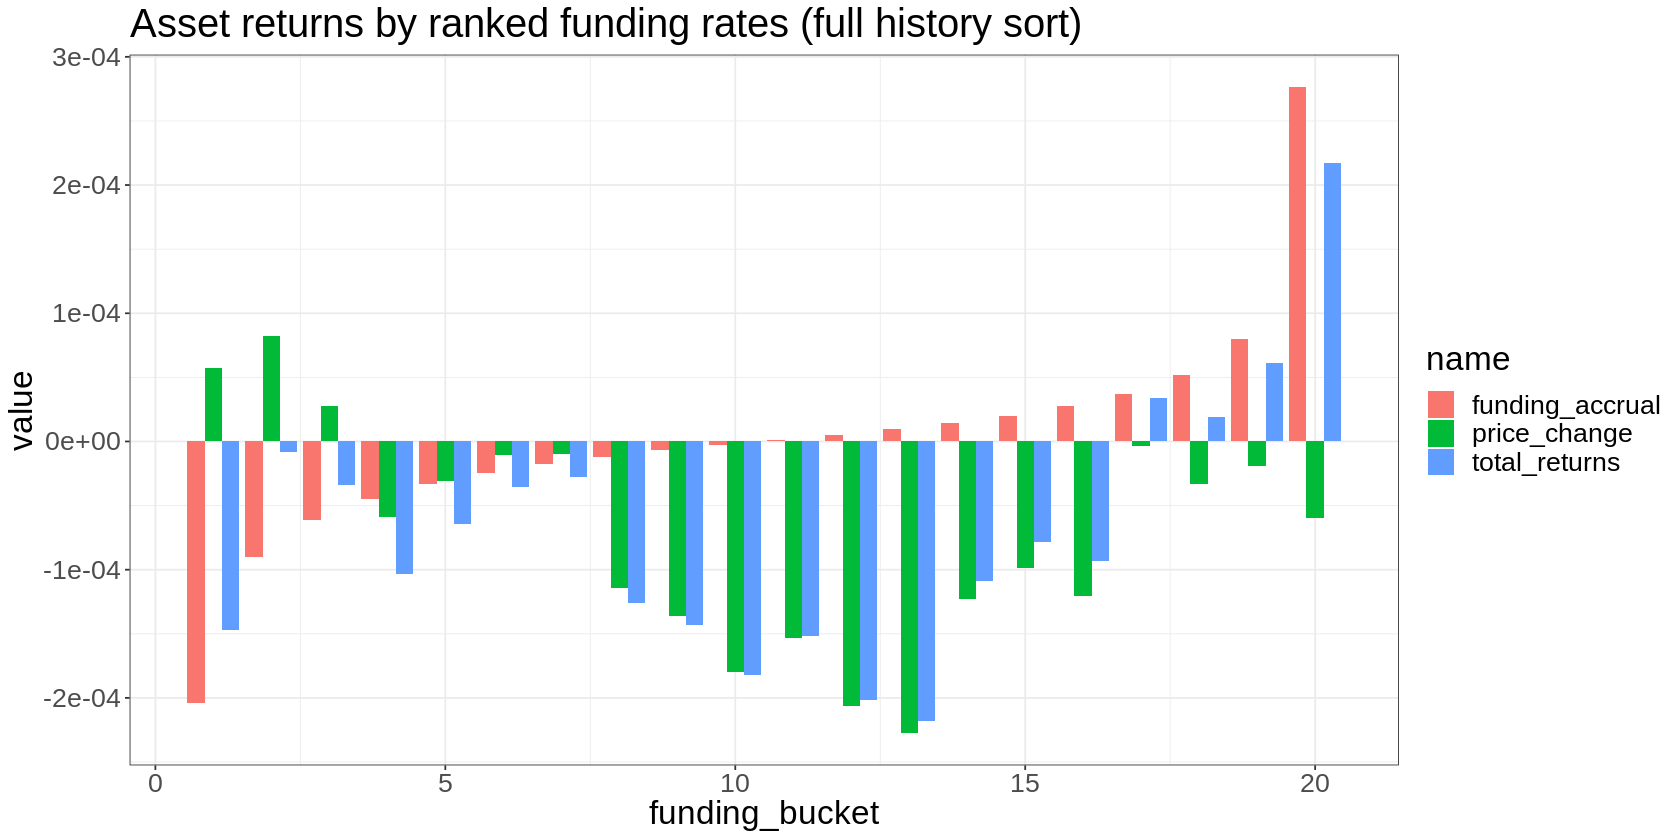

In [ ]:
funding_data %>%
  mutate(funding_bucket = ntile(avg_24, 20)) %>% 
  group_by(funding_bucket) %>%
  summarize(
    price_change = mean(price_change),
    funding_accrual = mean(funding_accrual),
    total_returns = mean(total_returns)
  ) %>%
  pivot_longer(-funding_bucket) %>%
  ggplot(aes(x=funding_bucket, y=value, fill=name)) + geom_bar(stat='identity', position = 'dodge') +
    ggtitle('Asset returns by ranked funding rates (full history sort)')

Woah look at those tails. It seems the magnitude of carry is importnat.

Now let's sort each asset separately - maybe what is important is whether the funding rate is remarkable *for a given asset*.

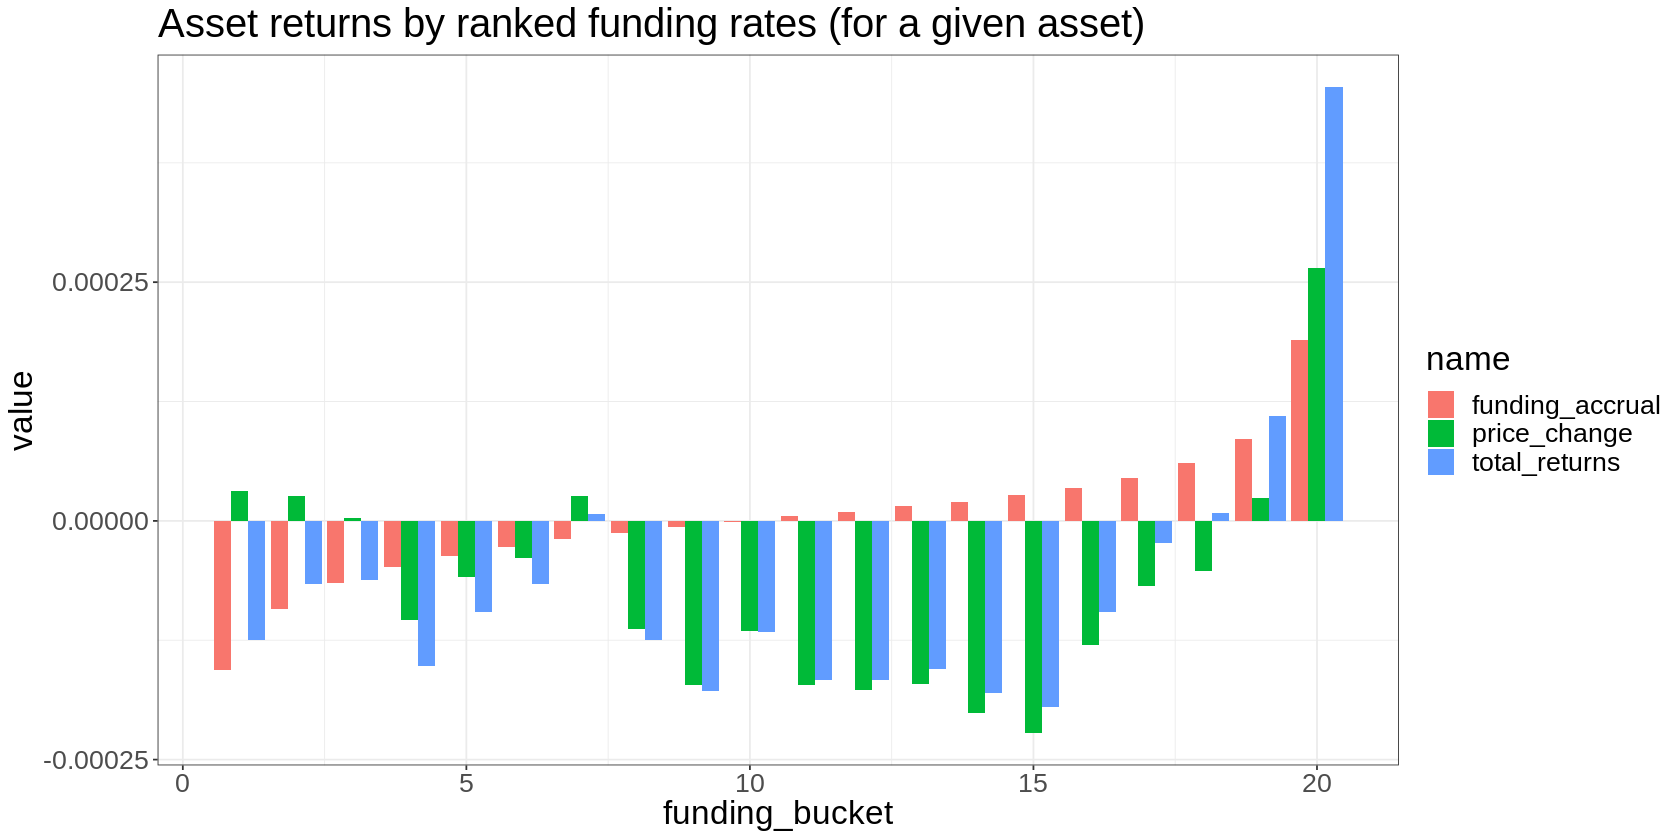

In [ ]:
funding_data %>%
  group_by(ticker) %>%
  mutate(funding_bucket = ntile(avg_24, 20)) %>% 
  group_by(funding_bucket) %>%
  summarize(
    price_change = mean(price_change),
    funding_accrual = mean(funding_accrual),
    total_returns = mean(total_returns)
  ) %>%
  pivot_longer(-funding_bucket) %>%
  ggplot(aes(x=funding_bucket, y=value, fill=name)) + geom_bar(stat='identity', position = 'dodge') +
    ggtitle('Asset returns by ranked funding rates (for a given asset)')

Woah... we see an effect similar to our squeeze effect at the extremes.

Where the most important thing seems to be whether the thing is trading at a deep discount for itself.

Note that this seems to be a long squeeze effect... The general carry effect looks much better behaved in the daily cross-sectional sort.

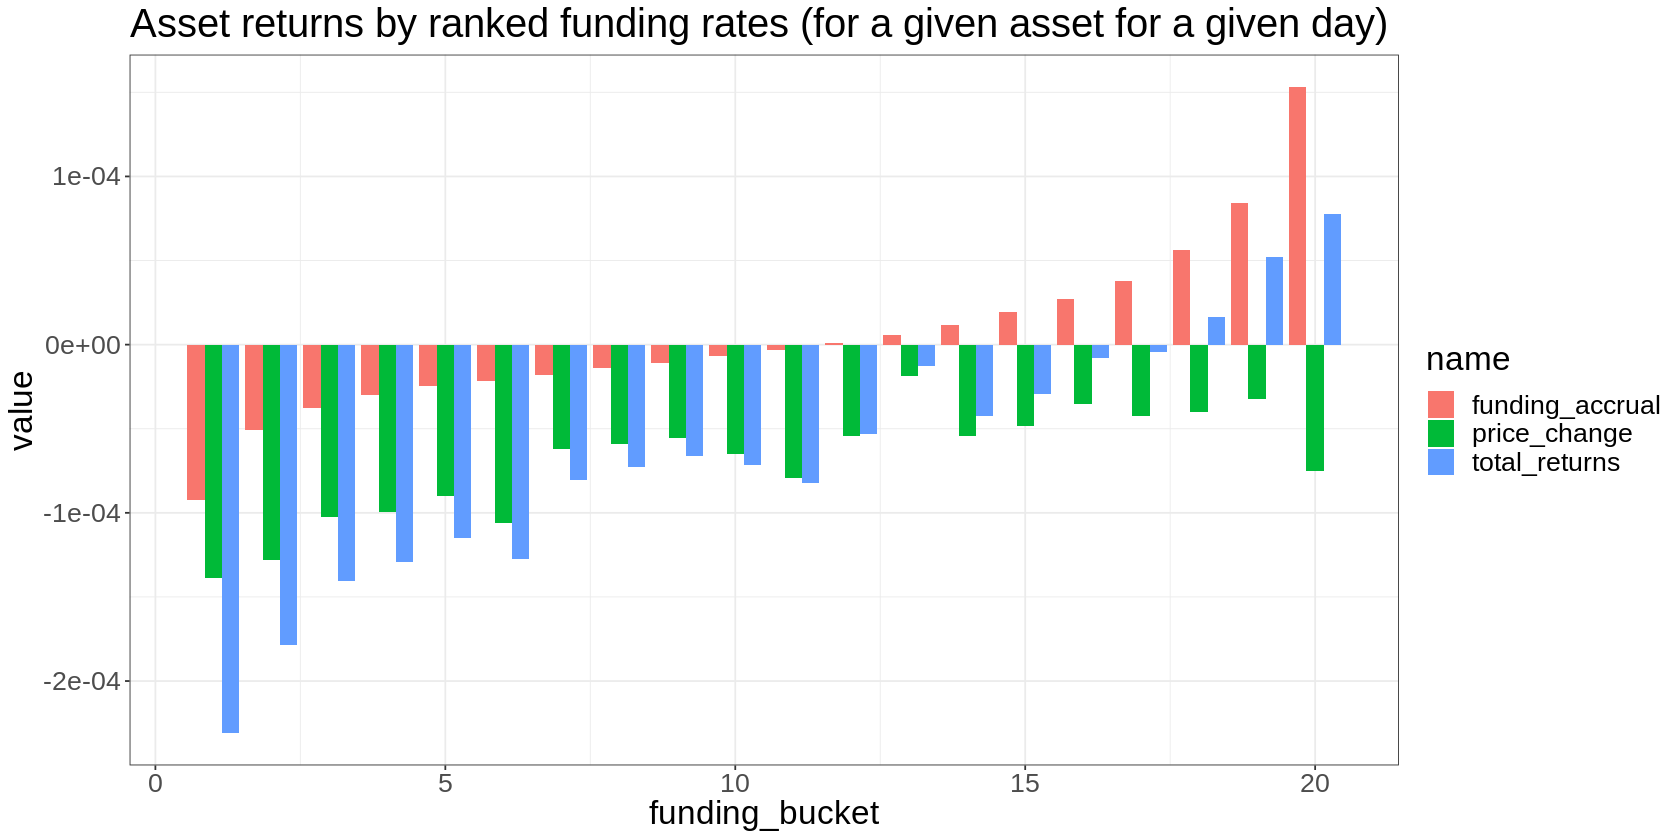

In [ ]:
funding_data %>%
  group_by(ticker) %>%
  mutate(funding_bucket = ntile(avg_24, 20)) %>% 
  group_by(date) %>%
  mutate(funding_bucket = ntile(funding_bucket, 20)) %>%
  group_by(funding_bucket) %>%
  summarize(
    price_change = mean(price_change),
    funding_accrual = mean(funding_accrual),
    total_returns = mean(total_returns)
  ) %>%
  pivot_longer(-funding_bucket) %>%
  ggplot(aes(x=funding_bucket, y=value, fill=name)) + geom_bar(stat='identity', position = 'dodge') +
    ggtitle('Asset returns by ranked funding rates (for a given asset for a given day)')

This is a slightly better behaved plot to the simple daily sort.

# Information Coefficient conditional on funding magnitude

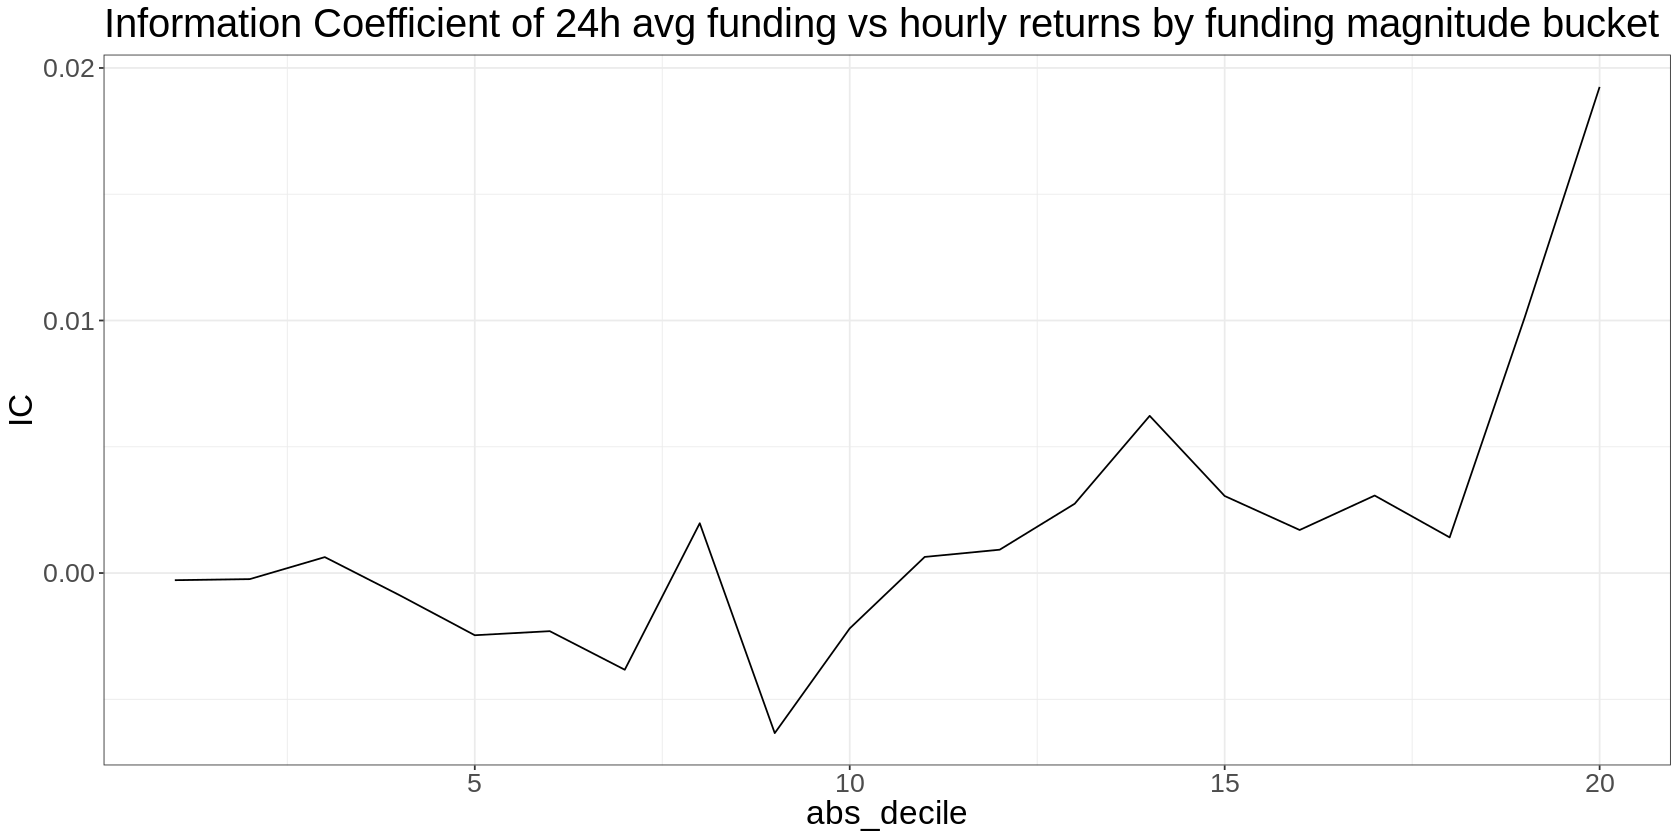

In [ ]:
funding_data %>%
  mutate(abs_decile = ntile(abs(avg_24), 20)) %>% 
  group_by(abs_decile) %>%
  summarize(IC = cor(avg_24, total_returns)) %>% 
  ggplot(aes(x=abs_decile, y=IC)) + 
    geom_line() +
    ggtitle('Information Coefficient of 24h avg funding vs hourly returns by funding magnitude bucket')

Let's look at the decay.

`summarise()` has grouped output by 'abs_decile'. You can override using the
`.groups` argument.


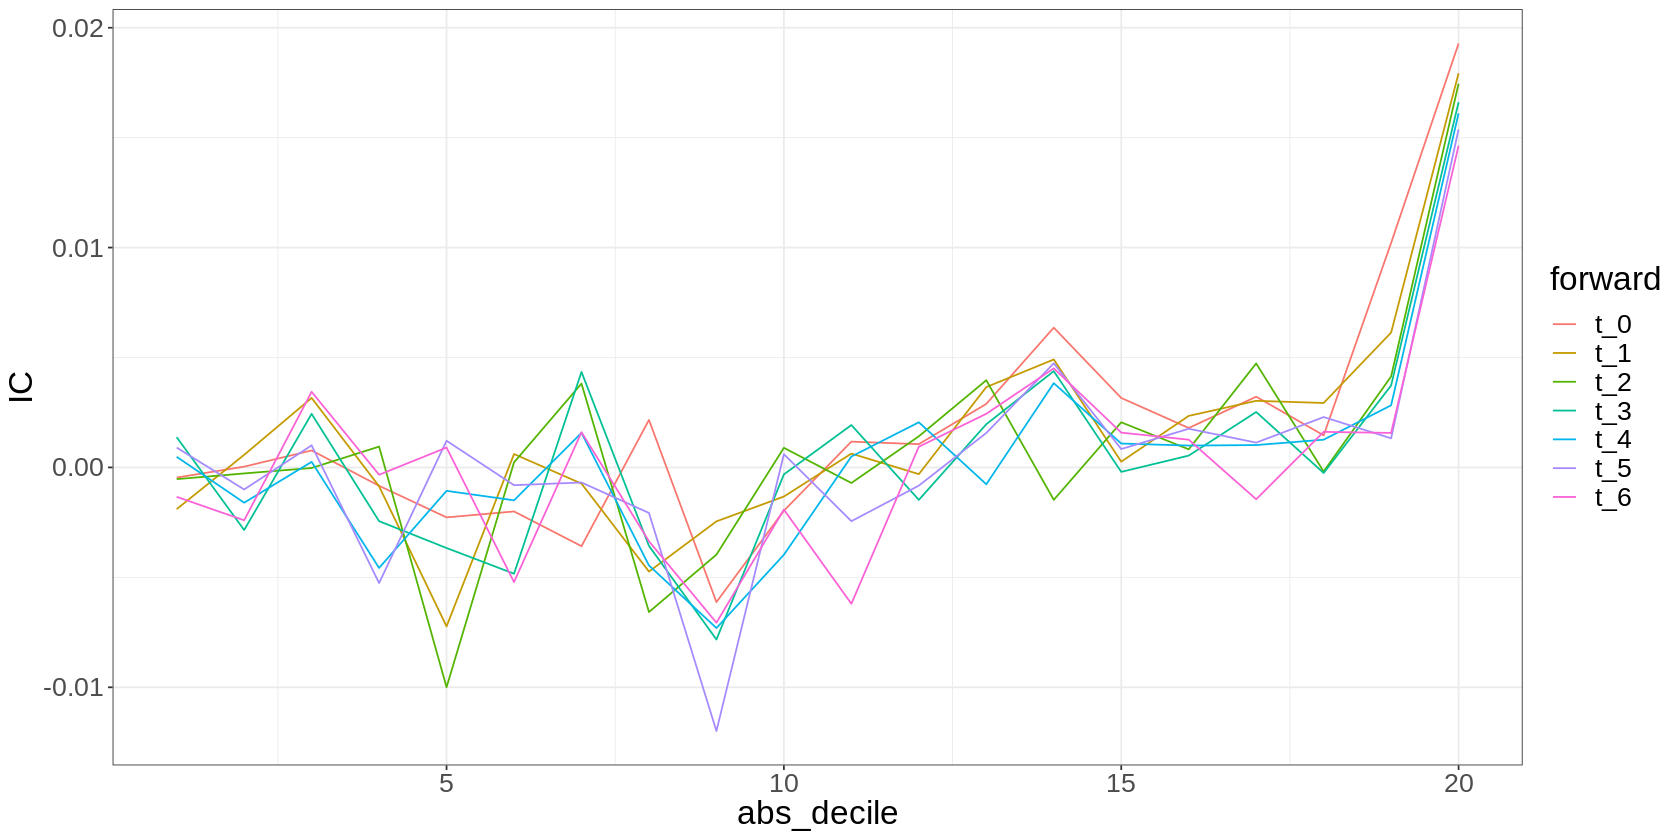

In [ ]:
forward_funding_data <- funding_data %>%
  mutate(abs_decile = ntile(abs(avg_24), 20)) %>%
  group_by(ticker) %>%
  arrange(date) %>%
  mutate(lag_avg_24 = lag(avg_24)) %>% 
  group_by(ticker) %>%
  mutate(
    t_0 = total_returns,
    t_1 = lead(total_returns, 1),
    t_2 = lead(total_returns, 2),
    t_3 = lead(total_returns, 3),
    t_4 = lead(total_returns, 4),
    t_5 = lead(total_returns, 5),
    t_6 = lead(total_returns, 6)
  ) %>%
  na.omit() %>%
  pivot_longer(starts_with('t_'), names_to = 'forward', values_to = 'returns') 

forward_funding_data %>%
  group_by(abs_decile, forward) %>%
  summarize(IC = cor(avg_24, returns)) %>%
  ggplot(aes(x=abs_decile, y=IC, color = forward)) + geom_line()

What if we lag it?

`summarise()` has grouped output by 'abs_decile'. You can override using the
`.groups` argument.


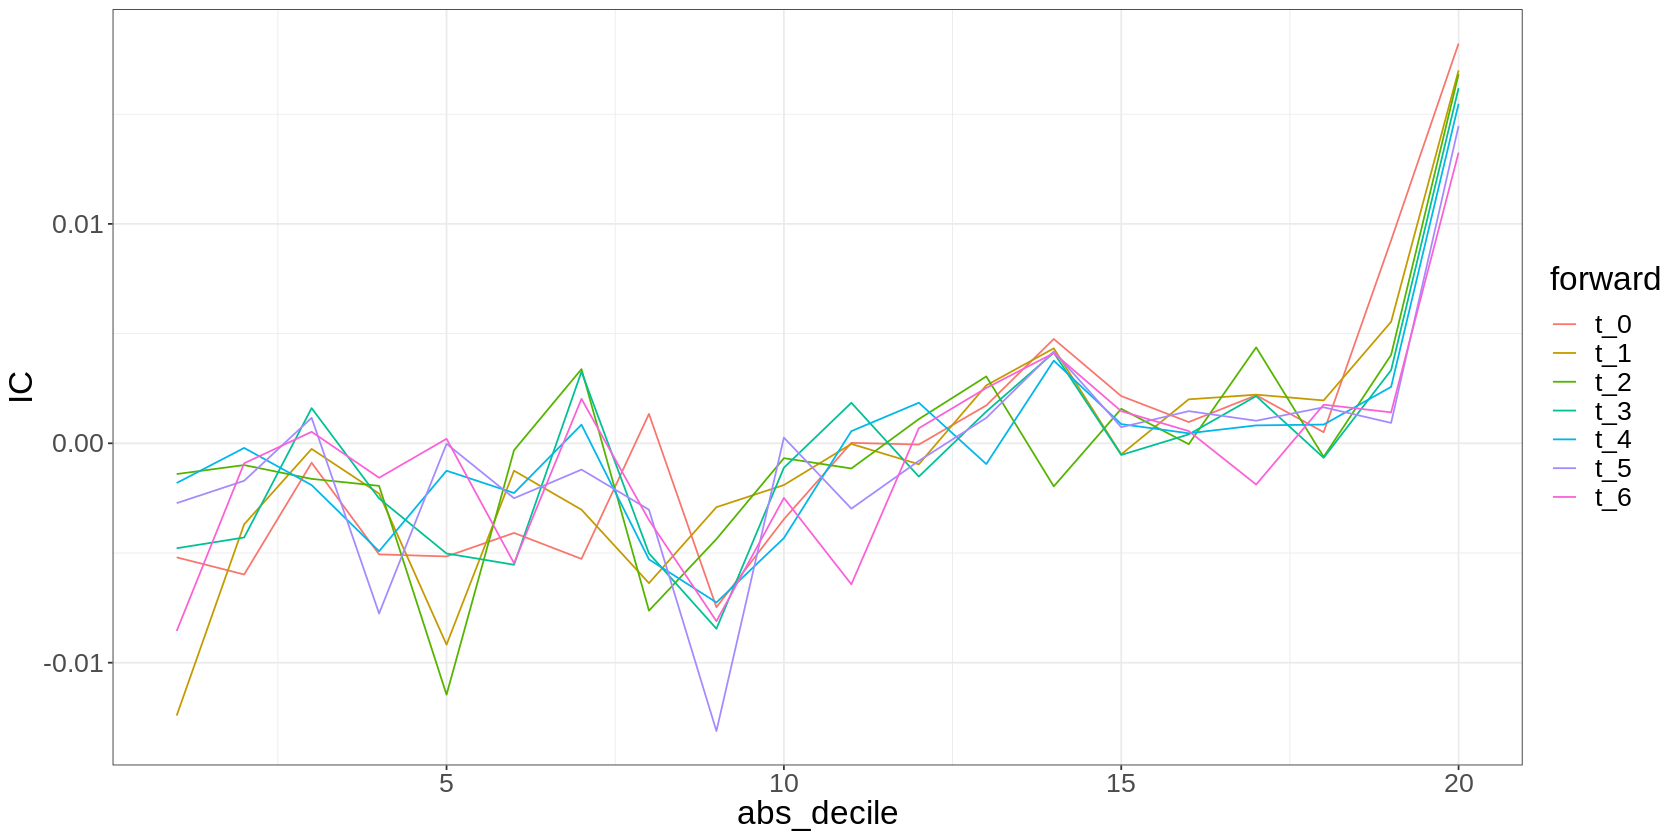

In [ ]:
forward_funding_data %>%
  group_by(abs_decile, forward) %>%
  summarize(IC = cor(lag_avg_24, returns)) %>%
  ggplot(aes(x=abs_decile, y=IC, color = forward)) + geom_line()

Interesting... See greater evidence of a reversal effect for benign rates - which is interesting but not really what we're looking for here.

Instead of sorting all our observations into deciles, what if we do it separately for each asset?

`summarise()` has grouped output by 'abs_decile'. You can override using the
`.groups` argument.


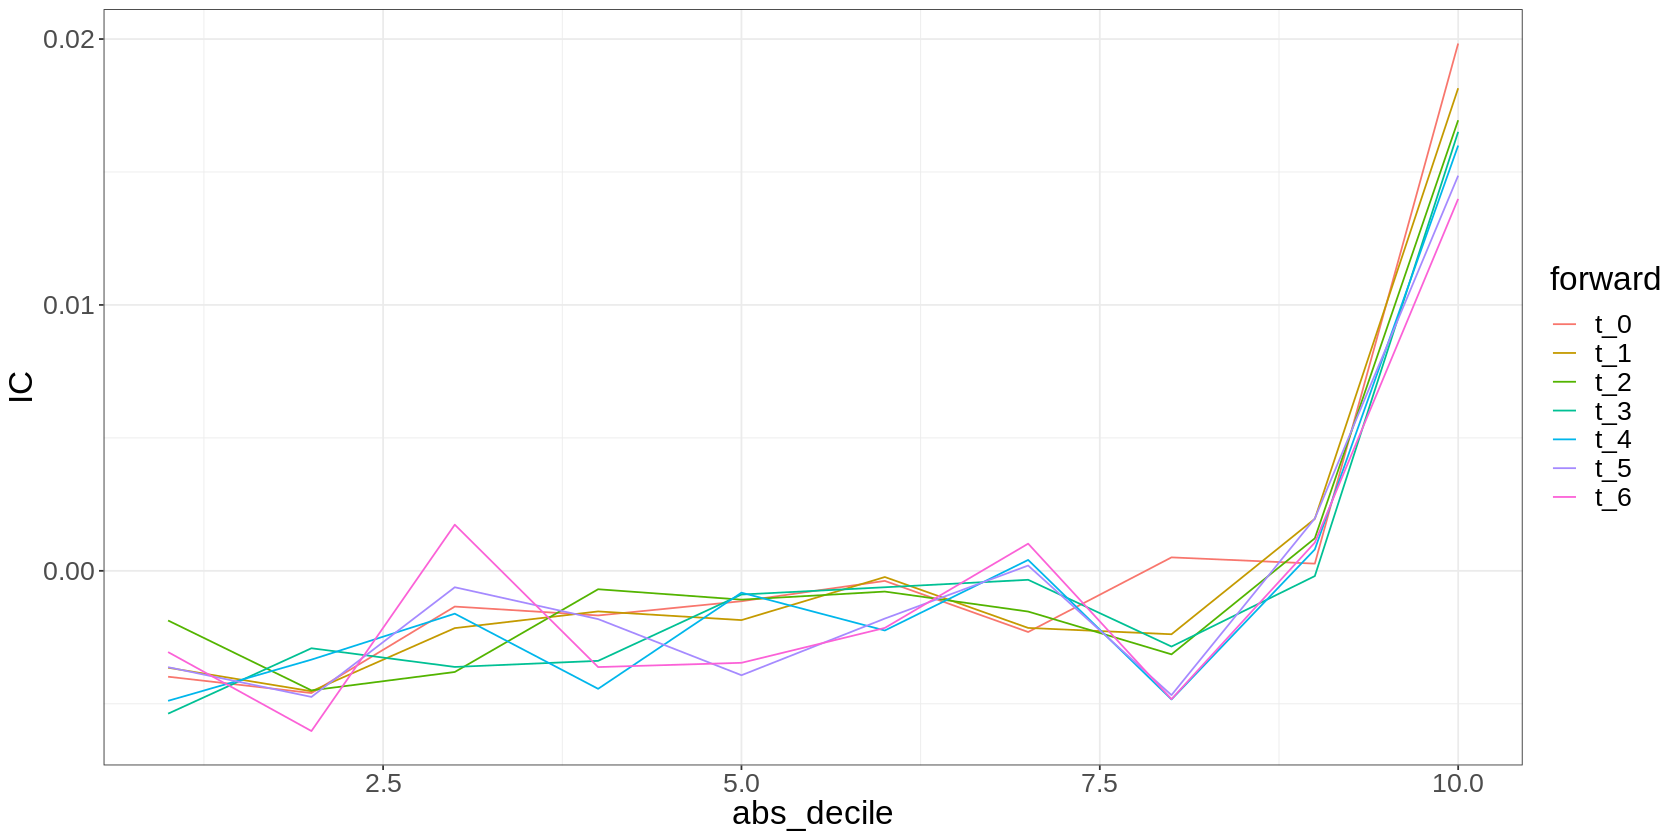

In [ ]:
funding_data %>%
  group_by(ticker) %>%
  mutate(abs_decile = ntile(abs(avg_24), 10)) %>%
  arrange(date) %>%
  group_by(ticker) %>%
  mutate(
    t_0 = total_returns,
    t_1 = lead(total_returns, 1),
    t_2 = lead(total_returns, 2),
    t_3 = lead(total_returns, 3),
    t_4 = lead(total_returns, 4),
    t_5 = lead(total_returns, 5),
    t_6 = lead(total_returns, 6)
  ) %>%
  na.omit() %>%
  pivot_longer(starts_with('t_'), names_to = 'forward', values_to = 'returns') %>% 
  group_by(abs_decile, forward) %>%
  summarize(IC = cor(avg_24, returns)) %>%
  ggplot(aes(x=abs_decile, y=IC, color = forward)) + geom_line()


This is interesting. Suggests that, perhaps the most important thing is whether the funding rate is extreme for the token (rather than necessarily by itself).

Do we see different behaviours for longs and shorts?

`summarise()` has grouped output by 'decile'. You can override using the
`.groups` argument.


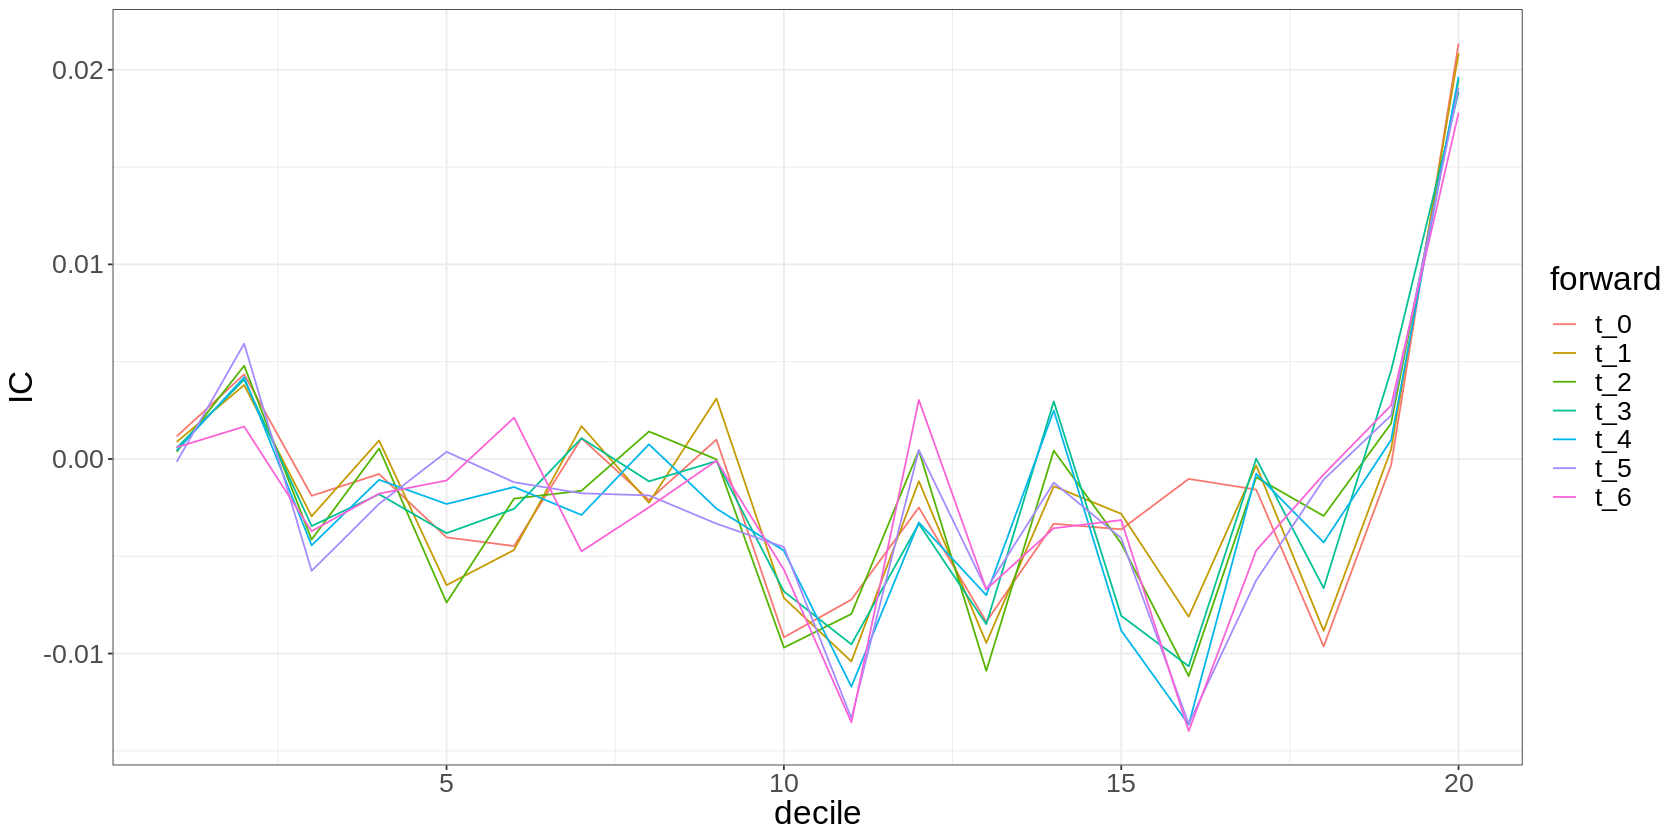

In [ ]:
funding_data %>%
  group_by(ticker) %>%
  mutate(decile = ntile((avg_24), 20)) %>%
  arrange(date) %>%
  group_by(ticker) %>%
  mutate(
    t_0 = total_returns,
    t_1 = lead(total_returns, 1),
    t_2 = lead(total_returns, 2),
    t_3 = lead(total_returns, 3),
    t_4 = lead(total_returns, 4),
    t_5 = lead(total_returns, 5),
    t_6 = lead(total_returns, 6)
  ) %>%
  na.omit() %>%
  pivot_longer(starts_with('t_'), names_to = 'forward', values_to = 'returns') %>% 
  group_by(decile, forward) %>%
  summarize(IC = cor(avg_24, returns)) %>%
  ggplot(aes(x=decile, y=IC, color = forward)) + geom_line()

We see a kinda reversal effect, except for at the extremes.

# The effectiveness of smoothing the funding rate

Now let's see what averages are more effective at explaining returns

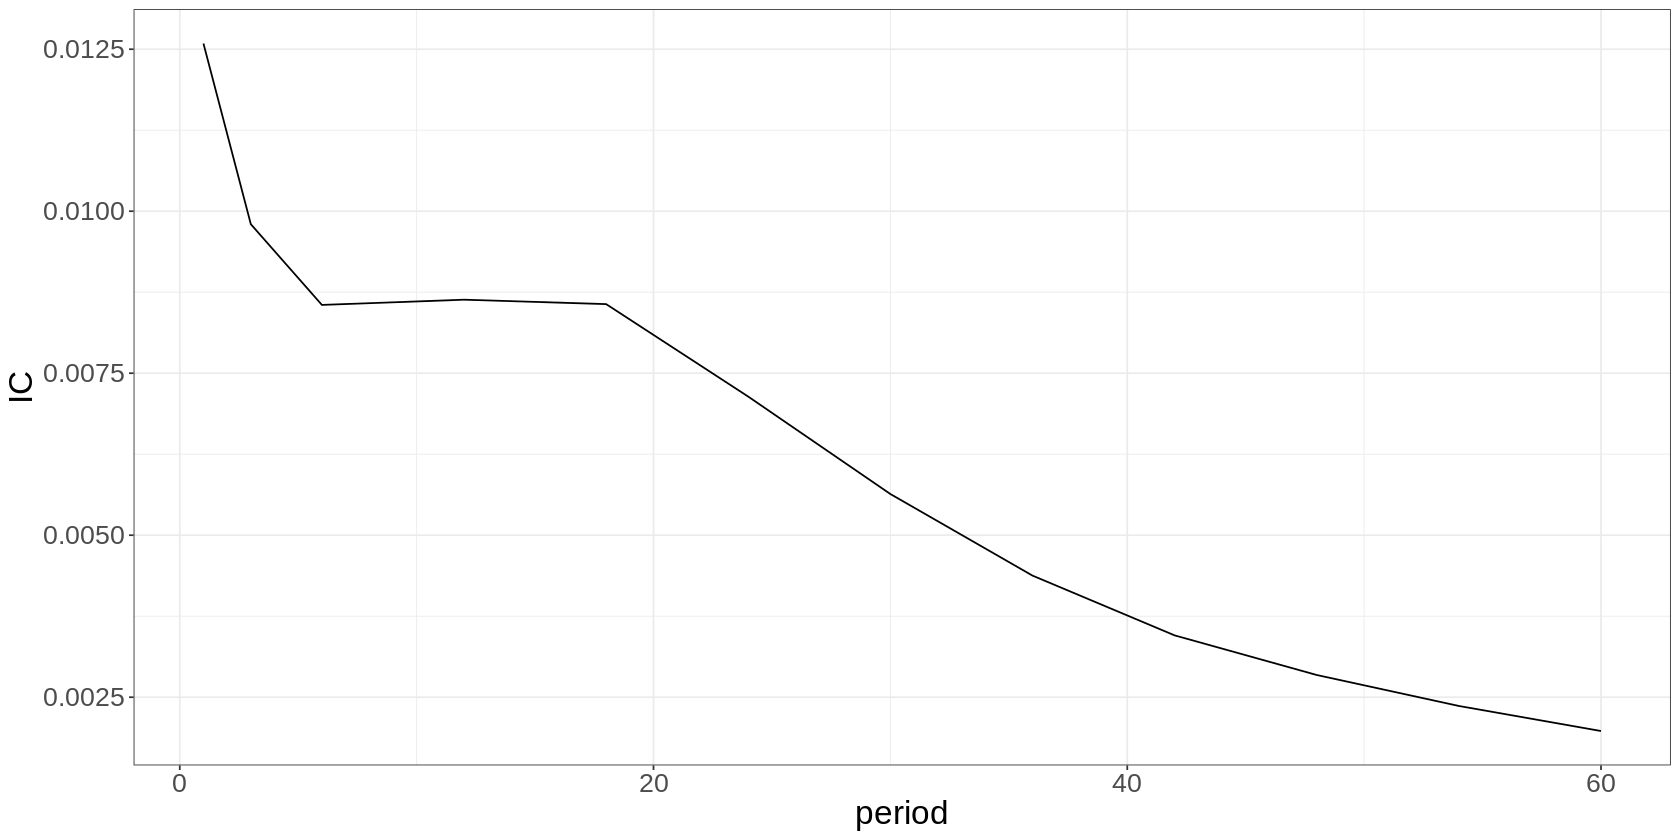

In [ ]:
funding_data %>% 
  pivot_longer(starts_with('avg_'), names_to = 'period', values_to = 'value') %>% 
  mutate(period = as.numeric(substr(period, 5, length(period)))) %>%
  group_by(period) %>%
  summarize(IC = cor(value, total_returns)) %>%
  ggplot(aes(x=period, y=IC)) + geom_line() 

See a pretty big drop-off after 3 hours. We'll look at the table. 

In [ ]:
funding_data %>% 
  pivot_longer(starts_with('avg_'), names_to = 'period', values_to = 'value') %>% 
  mutate(period = as.numeric(substr(period, 5, length(period)))) %>%
  group_by(period) %>%
  summarize(IC = cor(value, total_returns))

period,IC
<dbl>,<dbl>
1,0.012587941
3,0.009799351
6,0.008553871
12,0.008634441
18,0.008566150
24,0.007138626
30,0.005635288
36,0.004376229
42,0.003453925


The more dynamic we are the better our prediction.. but it's very hard to trade like this.

Now let's condition only on extreme stuff.

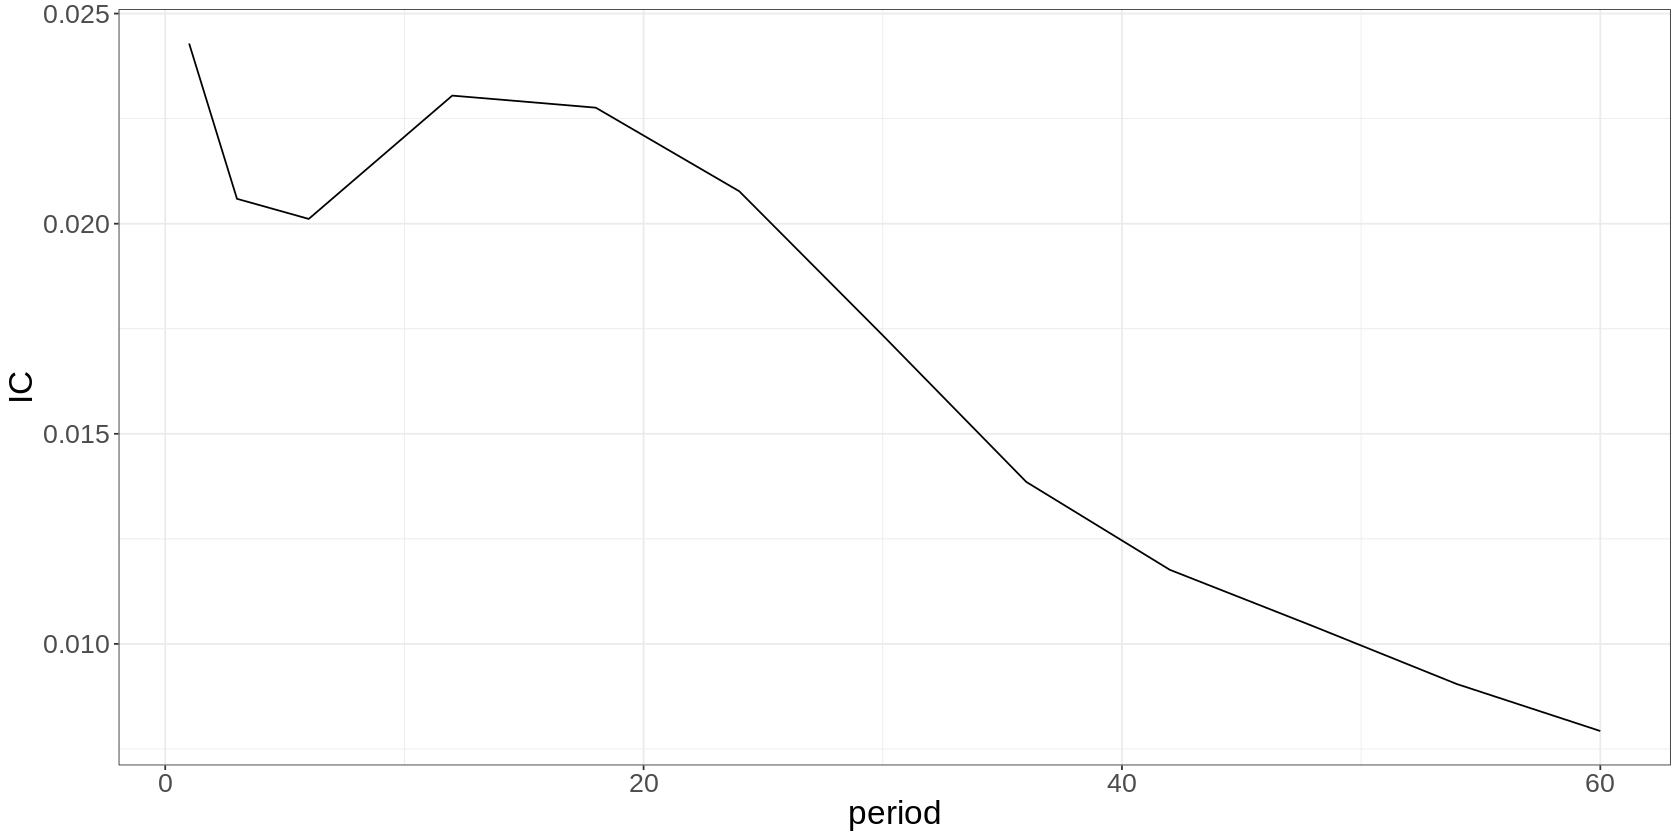

In [ ]:
funding_data %>% 
  group_by(date) %>%
  mutate(abs_decile = ntile(abs(avg_24), 20)) %>%
  filter(abs_decile == 20) %>%
  pivot_longer(starts_with('avg_'), names_to = 'period', values_to = 'value') %>% 
  mutate(period = as.numeric(substr(period, 5, length(period)))) %>%
  group_by(period) %>%
  summarize(IC = cor(value, total_returns)) %>%
  ggplot(aes(x=period, y=IC)) + geom_line()

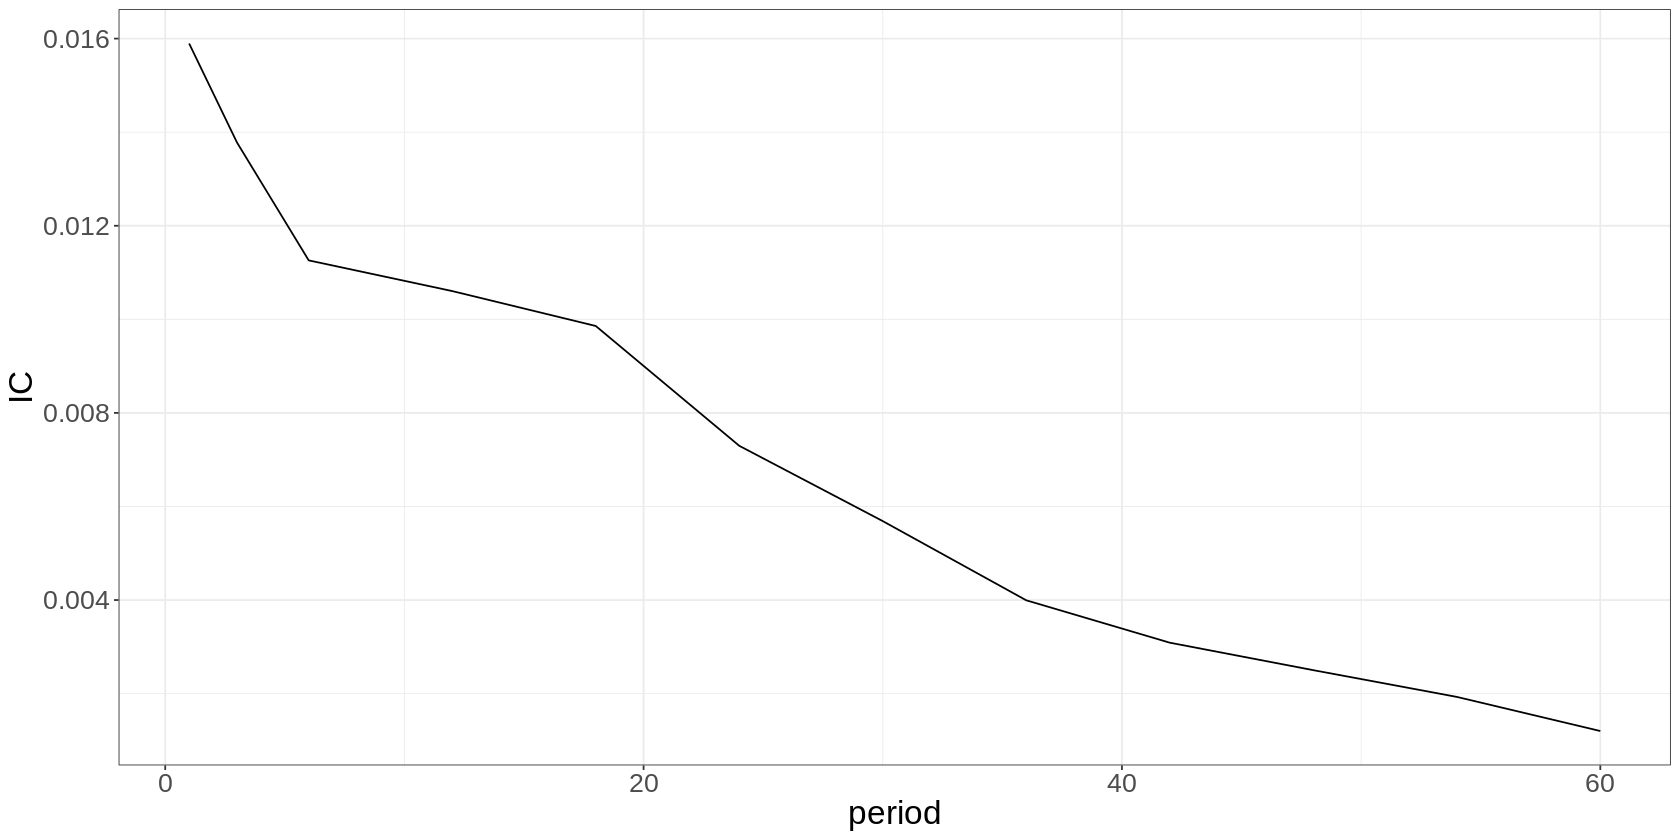

In [ ]:
funding_data %>% 
  mutate(abs_decile = ntile(abs(avg_24), 20)) %>%
  group_by(date) %>%
  mutate(abs_decile = ntile(abs(abs_decile), 20)) %>%
  filter(abs_decile == 20) %>%
  pivot_longer(starts_with('avg_'), names_to = 'period', values_to = 'value') %>% 
  mutate(period = as.numeric(substr(period, 5, length(period)))) %>%
  group_by(period) %>%
  summarize(IC = cor(value, total_returns)) %>%
  ggplot(aes(x=period, y=IC)) + geom_line()

Think about why this only explains half the variance of the one before at 1h 

# Extreme Backtest

Trade every hour based on hourly funding. 



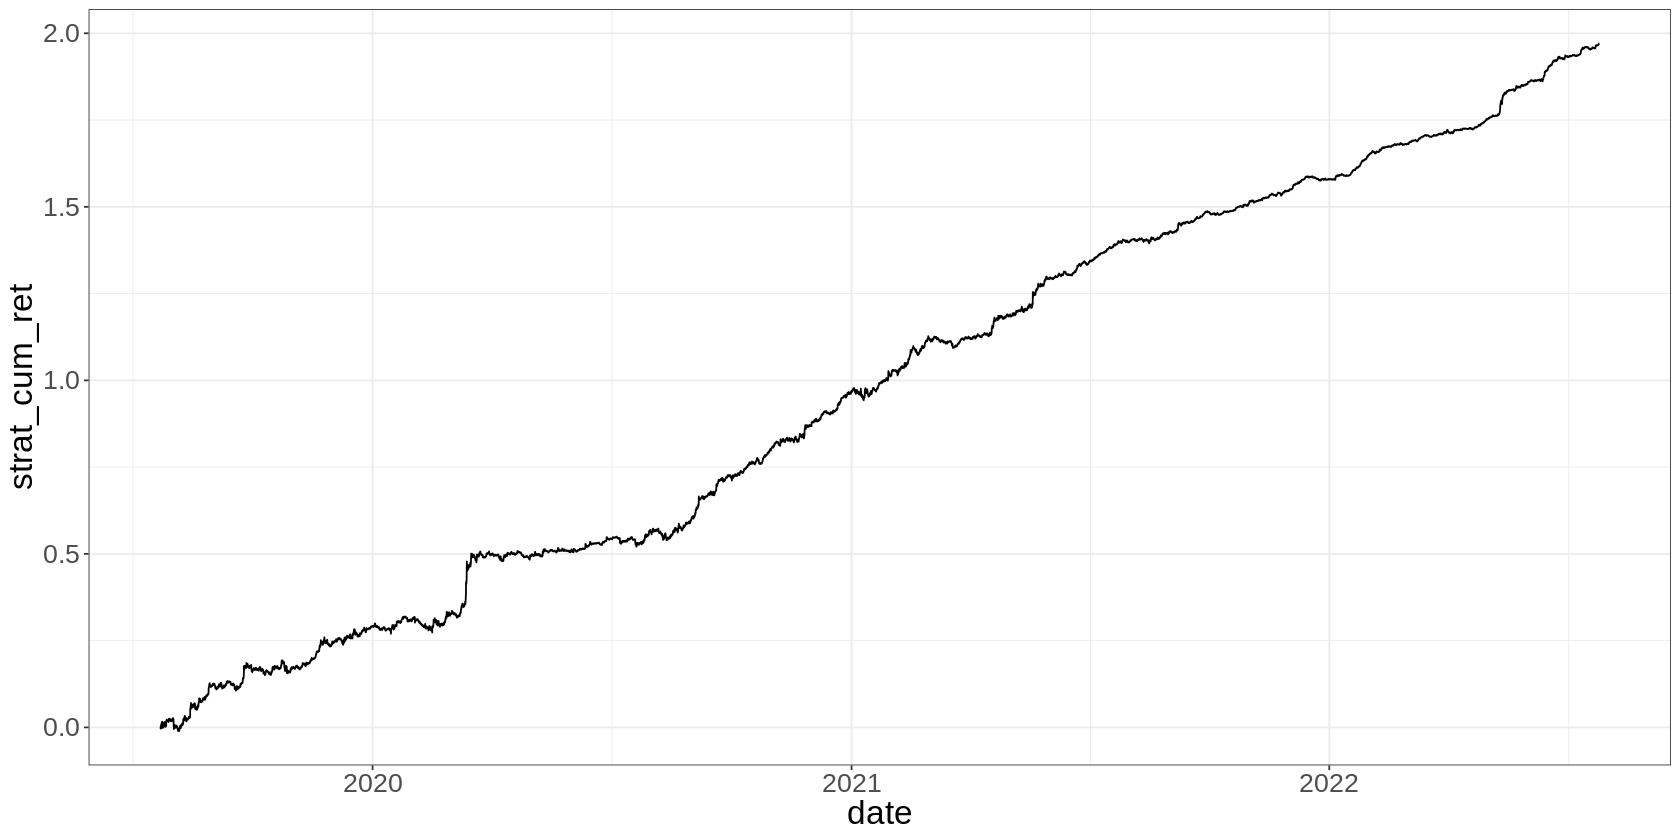

In [ ]:
cutoff <- 5

funding_data %>%
  group_by(date) %>%
  mutate(funding_bucket = ntile(avg_1, 50)) %>% 
  mutate(strat_returns = case_when(funding_bucket <= cutoff ~ -total_returns, funding_bucket >= 50 - cutoff + 1 ~ total_returns, TRUE ~ 0)) %>%
  group_by(date) %>%
  summarize(strat_simple_returns = mean(exp(strat_returns)-1)) %>%
  arrange(date) %>%
  mutate(strat_cum_ret = cumsum(log(strat_simple_returns + 1))) %>%
  ggplot(aes(x=date, y=strat_cum_ret)) + geom_line()

Obviously this is ridiculous - but it provides insight. Let's look at the 24h avg now, still trading hourly.

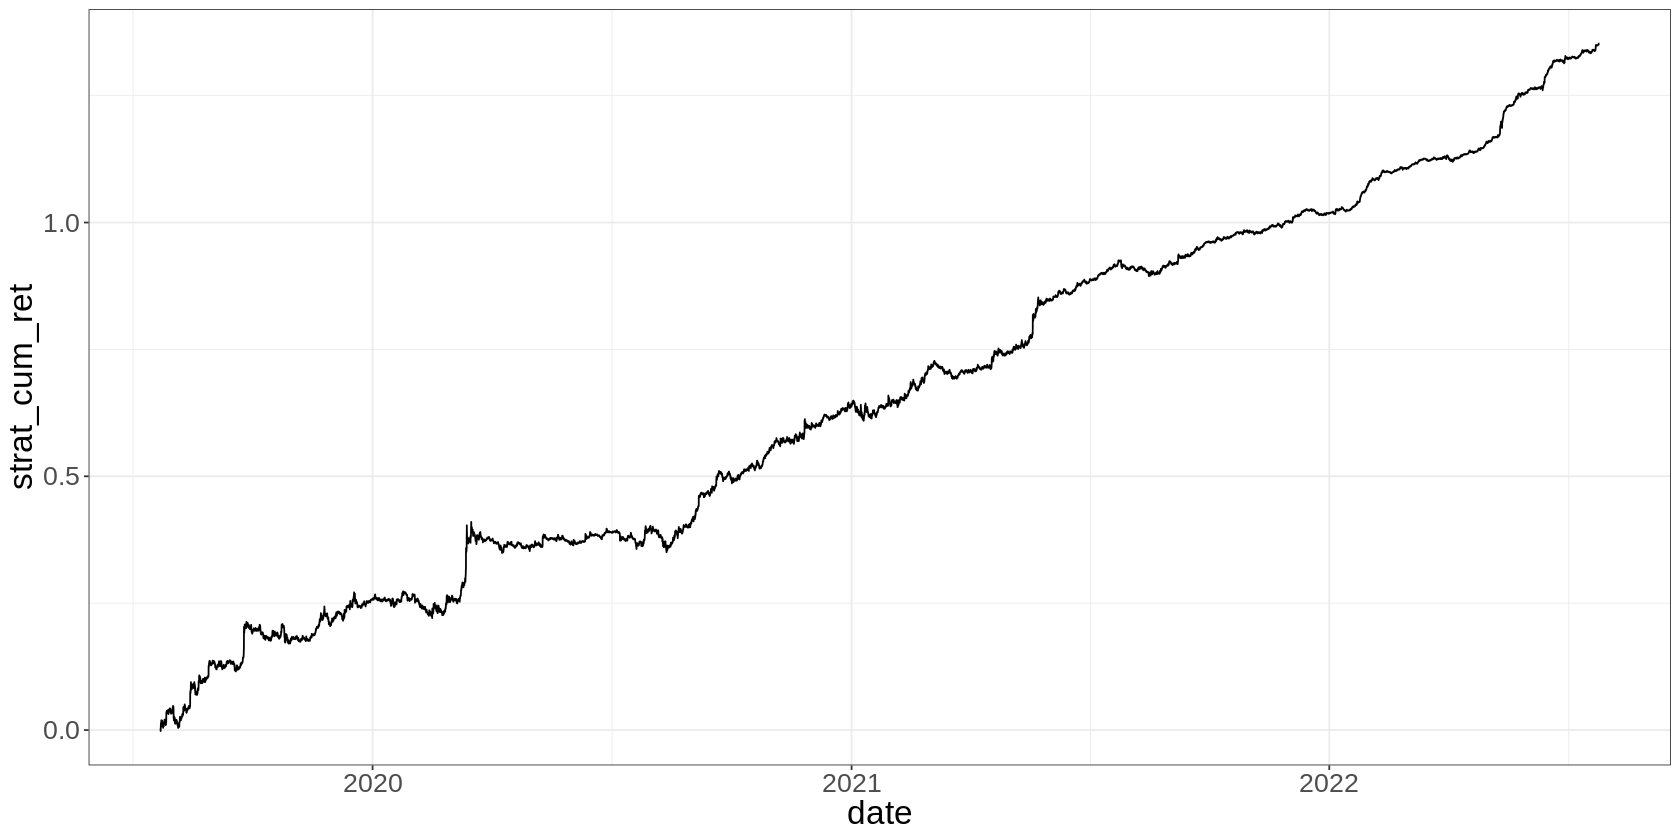

In [ ]:
cutoff <- 5

funding_data %>%
  group_by(date) %>%
  mutate(funding_bucket = ntile(avg_24, 50)) %>% 
  mutate(strat_returns = case_when(funding_bucket <= cutoff ~ -total_returns, funding_bucket >= 50 - cutoff + 1 ~ total_returns, TRUE ~ 0)) %>%
  group_by(date) %>%
  summarize(strat_simple_returns = mean(exp(strat_returns)-1)) %>%
  arrange(date) %>%
  mutate(strat_cum_ret = cumsum(log(strat_simple_returns + 1))) %>%
  ggplot(aes(x=date, y=strat_cum_ret)) + geom_line()

Still very active, ofc. Let's look at 60 hours.

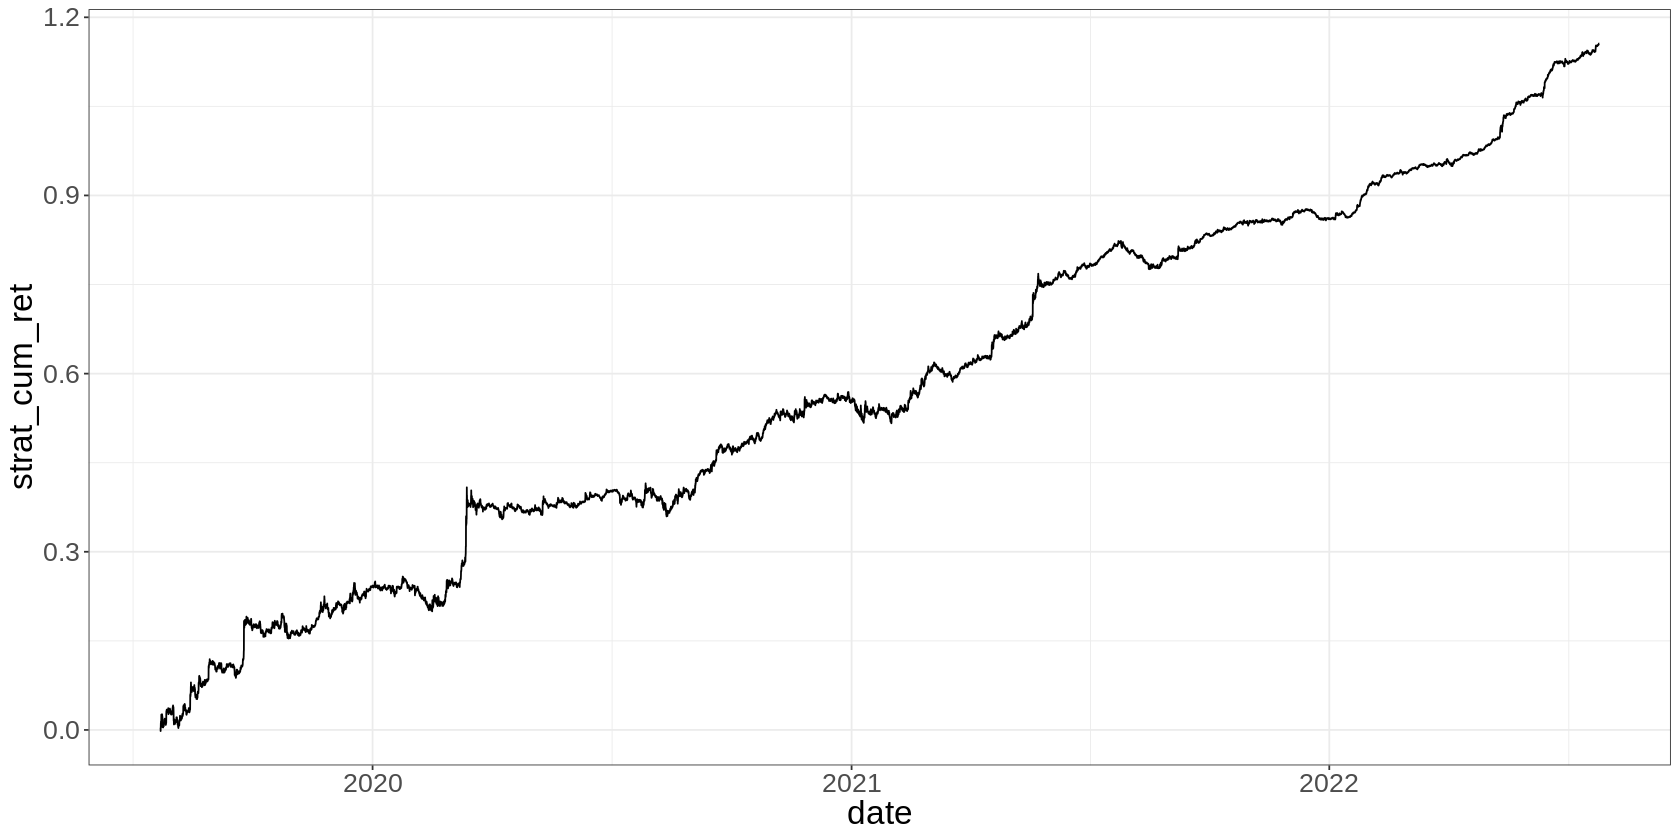

In [ ]:
cutoff <- 5

funding_data %>%
  group_by(date) %>%
  mutate(funding_bucket = ntile(avg_60, 50)) %>% 
  mutate(strat_returns = case_when(funding_bucket <= cutoff ~ -total_returns, funding_bucket >= 50 - cutoff + 1 ~ total_returns, TRUE ~ 0)) %>%
  group_by(date) %>%
  summarize(strat_simple_returns = mean(exp(strat_returns)-1)) %>%
  arrange(date) %>%
  mutate(strat_cum_ret = cumsum(log(strat_simple_returns + 1))) %>%
  ggplot(aes(x=date, y=strat_cum_ret)) + geom_line()

Now, instead of sorting by the funding value, let's sort by how big a deal that fuunding rate is for each asset.

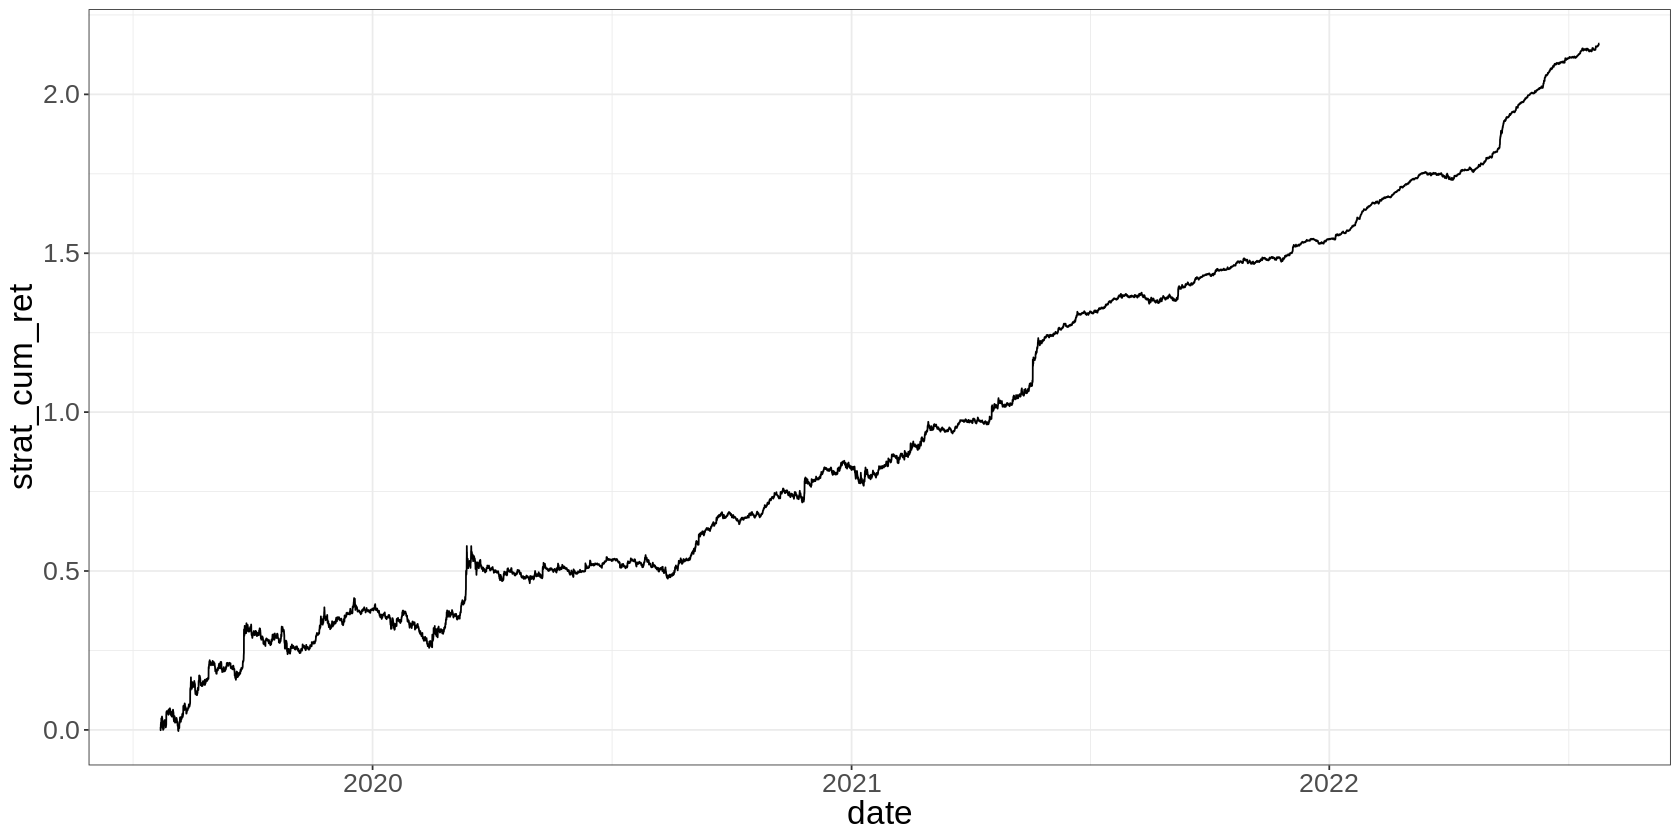

In [ ]:
cutoff <- 10

funding_data %>%
  group_by(ticker) %>%
  mutate(funding_bucket = ntile(avg_24, 50)) %>% 
  group_by(date) %>%
  mutate(funding_bucket = ntile(funding_bucket, 50)) %>%
  mutate(strat_returns = case_when(funding_bucket <= cutoff ~ -total_returns, funding_bucket >= 50 - cutoff + 1 ~ total_returns, TRUE ~ 0)) %>%
  group_by(date) %>%
  summarize(strat_simple_returns = mean(exp(strat_returns)-1)) %>%
  arrange(date) %>%
  mutate(strat_cum_ret = cumsum(log(strat_simple_returns + 1))) %>%
  ggplot(aes(x=date, y=strat_cum_ret)) + geom_line()

We see that's a bit more effective, as we expected.

# Summary

We clearly have a useful feature here.

If we want to build a standalone strategy out of it, we need to do some simulation to work out how to navigate the trade-off between:
 - how dynamic the funding feature is (could probably improve things with an EMA)
 - how often we look to rebalance 
 - the tolerance around rebalances.

This is a pretty active, extreme effect, so it wouldn't really be an "easy" trade.